In [1]:
import warnings
warnings.filterwarnings("ignore")
from copy import deepcopy
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd
import sys

sys.path.append("/code")

from tqdm import tqdm
import torch
import time
# device = torch.device('cpu')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# import gym
# import recogym

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

torch.backends.cudnn.benchmark = torch.cuda.is_available()
if torch.cuda.is_available():
    torch.set_float32_matmul_precision("high")  # TF32 = big speedup on Ada


from sklearn.utils import check_random_state

# implementing OPE of the IPWLearner using synthetic bandit data
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt

from scipy.special import softmax
import optuna
# from memory_profiler import profile


from estimators import (
    DirectMethod as DM
)

from simulation_utils import (
    eval_policy,
    generate_dataset,
    create_simulation_data_from_pi,
    get_train_data,
    get_opl_results_dict,
    CustomCFDataset,
    calc_reward,
    get_weights_info
)

from models import (    
    LinearCFModel,
    NeighborhoodModel,
    BPRModel, 
    RegressionModel
)

from training_utils import (
    train,
    validation_loop, 
    cv_score_model
 )

# from trainer_trials import (
#     regression_trainer_trial,
#     neighberhoodmodel_trainer_trial
# )

from trainer_trials_modular import (
    regression_trainer_trial,
    neighberhoodmodel_trainer_trial
)


random_state=12345
random_ = check_random_state(random_state)

pd.options.display.float_format = '{:,.8f}'.format

Using device: cuda
Using device: cuda
Using device: cuda


## Learning

We will run several simulations on a generated dataset, the dataset is generated like this:
$$ \text{We have users U and actions A } u_i \sim N(0, I_{emb_dim}) \ a_i \sim N(0, I_{emb_dim})$$
$$ p_{ij} = 1 / (5 + e^{-(u_i.T a_j)}) $$
$$r_{ij} \sim Bin(p_{ij})$$

We have a policy $\pi$
and it's ground truth reward is calculated by
$$R_{gt} = \sum_{i}{\sum_{j}{\pi_{ij} * p_{ij}}} $$

Our parameters for the dataset will be
$$EmbDim = 5$$
$$NumActions= 150$$
$$NumUsers = 150$$
$$NeighborhoodSize = 6$$

to learn a new policy from $\pi$ we will sample from:
$$\pi_{start} = (1-\epsilon)*\pi + \epsilon * \pi_{random}$$

In [2]:
dataset_params = dict(
                    n_actions= 500,
                    n_users = 500,
                    emb_dim = 16,
                    # sigma = 0.1,
                    eps = 0.6, # this is the epsilon for the noise in the ground truth policy representation
                    ctr = 0.1
                    )

train_dataset = generate_dataset(dataset_params)

Random Item CTR: 0.07066414727263938
Optimal greedy CTR: 0.09999926940951757
Second Best greedy CTR: 0.0980913477695915
Optimal Stochastic CTR: 0.09995326955796031
second Best Stochastic CTR: 0.08595012935428775
Our Initial CTR: 0.08610747363354625


In [3]:
num_runs = 1
batch_size = 200
num_neighbors = 6
n_trials_for_optuna = 20
# num_rounds_list = [500, 1000, 2000, 10000, 20000]
# num_rounds_list = [500, 1000, 2000]
num_rounds_list = [15000]


# Manually define your best parameters
best_params_to_use = {
    "lr": 0.096,  # Learning rate
    "num_epochs": 5,  # Number of training epochs
    "batch_size": 64,  # Batch size for training
    "num_neighbors": 8,  # Number of neighbors for neighborhood model
    "lr_decay": 0.85  # Learning rate decay factor
}


### 1

$$emb = 0.7 * gt + 0.3 * noise$$
$$lr = 0.005$$
$$n_{epochs} = 1$$
$$BatchSize=50$$

In [4]:
print("Value of num_rounds_list:", num_rounds_list)

# Run the optimization
df4, study_df = regression_trainer_trial(num_runs, num_neighbors, num_rounds_list, train_dataset, batch_size, val_size=10000, n_trials=n_trials_for_optuna, prev_best_params=best_params_to_use)

# # Print best hyperparameters for each training size
# print("\n=== BEST HYPERPARAMETERS BY TRAINING SIZE ===")
# for train_size, params in best_hyperparams_by_size.items():
#     print(f"\nTraining Size: {train_size}")
#     # print(f"Best Reward: {params['reward']:.6f}")
#     print("Parameters:")
#     for param_name, value in params['params'].items():
#         print(f"  {param_name}: {value}")
# print("===========================\n")

# Show the performance metrics
df4[['policy_rewards', 'ipw', 'reg_dm', 'conv_dm', 'conv_dr', 'conv_sndr', 'action_diff_to_real', 'action_delta', 'context_diff_to_real', 'context_delta']]

Value of num_rounds_list: [15000]
Simulation time for 10000 samples: 0.025790929794311523 seconds
[Regression] Baseline regression model fit time: 0.09s
Num samples is 10000
{'gini': np.float64(0.478996349703288), 'ess': np.float64(4058.017105190712), 'max_wi': np.float64(45.54324787336438), 'min_wi': np.float64(0.010558493651857803)}
Eval time: 0.4638173580169678 seconds


[I 2025-11-17 18:08:23,442] A new study created in memory with name: no-name-a531166b-4321-4873-be3b-534054b275fb


Evaluation total results time: 0.84 seconds

=== [Regression] Training size 15000, run 0 ===
Simulation time for 25000 samples: 0.059871673583984375 seconds


  0%|          | 0/20 [00:00<?, ?it/s]


[Regression] Optuna Trial 0


Best trial: 0. Best value: -inf:   5%|▌         | 1/20 [00:04<01:21,  4.29s/it]

actual reward: [0.07955068]
Validation weights_info: {'gini': np.float64(0.9857038753062568), 'ess': np.float64(31.86190075448896), 'max_wi': np.float64(1831.9937353357102), 'min_wi': np.float64(0.0)}
Estimated reward: 0.083344
Cross-validated error: 0.002843
Final score CI (reward +- 2*error): [0.077659, 0.089030]
Standard error: 0.000181
Final t_dist CI (reward +- t_0.975*se_hat): [0.082989, 0.083700]
[I 2025-11-17 18:08:27,729] Trial 0 finished with value: -inf and parameters: {'lr': 0.096, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.85}. Best is trial 0 with value: -inf.

[Regression] Optuna Trial 1


Best trial: 1. Best value: 0.0808131:  10%|█         | 2/20 [00:08<01:20,  4.46s/it]

actual reward: [0.08631411]
Validation weights_info: {'gini': np.float64(0.9830344058806368), 'ess': np.float64(147.50924920136745), 'max_wi': np.float64(198.01398031858722), 'min_wi': np.float64(2.859075632263167e-31)}
Estimated reward: 0.088033
Cross-validated error: 0.003610
Final score CI (reward +- 2*error): [0.080813, 0.095253]
Standard error: 0.000312
Final t_dist CI (reward +- t_0.975*se_hat): [0.087422, 0.088644]
[I 2025-11-17 18:08:32,308] Trial 1 finished with value: 0.08081308733772938 and parameters: {'lr': 0.0461946574153637, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.9273383657728299}. Best is trial 1 with value: 0.08081308733772938.

[Regression] Optuna Trial 2


Best trial: 1. Best value: 0.0808131:  15%|█▌        | 3/20 [00:10<00:52,  3.11s/it]

actual reward: [0.08695034]
Validation weights_info: {'gini': np.float64(0.9899676348040438), 'ess': np.float64(26.09271962990292), 'max_wi': np.float64(940.6619038161856), 'min_wi': np.float64(1.1108242489002437e-08)}
Estimated reward: 0.089806
Cross-validated error: 0.007355
Final score CI (reward +- 2*error): [0.075096, 0.104517]
Standard error: 0.000432
Final t_dist CI (reward +- t_0.975*se_hat): [0.088960, 0.090653]
[I 2025-11-17 18:08:33,818] Trial 2 finished with value: -inf and parameters: {'lr': 0.018402249204762293, 'num_epochs': 2, 'batch_size': 128, 'lr_decay': 0.9488443623133109}. Best is trial 1 with value: 0.08081308733772938.

[Regression] Optuna Trial 3


Best trial: 1. Best value: 0.0808131:  20%|██        | 4/20 [00:11<00:36,  2.25s/it]

actual reward: [0.08693152]
Validation weights_info: {'gini': np.float64(0.928778638145386), 'ess': np.float64(608.3154530877551), 'max_wi': np.float64(52.47648362177881), 'min_wi': np.float64(1.488001781023234e-05)}
Estimated reward: 0.082223
Cross-validated error: 0.000776
Final score CI (reward +- 2*error): [0.080671, 0.083775]
Standard error: 0.000644
Final t_dist CI (reward +- t_0.975*se_hat): [0.080960, 0.083486]
[I 2025-11-17 18:08:34,752] Trial 3 finished with value: 0.08067101561736169 and parameters: {'lr': 0.03095358632131358, 'num_epochs': 1, 'batch_size': 512, 'lr_decay': 0.9344163723455602}. Best is trial 1 with value: 0.08081308733772938.

[Regression] Optuna Trial 4


Best trial: 1. Best value: 0.0808131:  25%|██▌       | 5/20 [00:13<00:32,  2.15s/it]

actual reward: [0.08636243]
Validation weights_info: {'gini': np.float64(0.9939048831088673), 'ess': np.float64(15.840209254893704), 'max_wi': np.float64(1229.480398168883), 'min_wi': np.float64(2.3607140927327306e-14)}
Estimated reward: 0.095461
Cross-validated error: 0.006583
Final score CI (reward +- 2*error): [0.082295, 0.108627]
Standard error: 0.000335
Final t_dist CI (reward +- t_0.975*se_hat): [0.094804, 0.096118]
[I 2025-11-17 18:08:36,729] Trial 4 finished with value: -inf and parameters: {'lr': 0.04967794215666308, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.9309529822557874}. Best is trial 1 with value: 0.08081308733772938.

[Regression] Optuna Trial 5


Best trial: 1. Best value: 0.0808131:  30%|███       | 6/20 [00:14<00:26,  1.92s/it]

actual reward: [0.08613056]
Validation weights_info: {'gini': np.float64(0.040049921136225554), 'ess': np.float64(9943.280726077457), 'max_wi': np.float64(1.2134745385717725), 'min_wi': np.float64(0.8492313461092299)}
Estimated reward: 0.080993
Cross-validated error: 0.000482
Final score CI (reward +- 2*error): [0.080030, 0.081957]
Standard error: 0.002023
Final t_dist CI (reward +- t_0.975*se_hat): [0.077027, 0.084960]
[I 2025-11-17 18:08:38,188] Trial 5 finished with value: 0.08003006307124609 and parameters: {'lr': 0.00022067777121379016, 'num_epochs': 3, 'batch_size': 512, 'lr_decay': 0.8897681050166335}. Best is trial 1 with value: 0.08081308733772938.

[Regression] Optuna Trial 6


Best trial: 1. Best value: 0.0808131:  35%|███▌      | 7/20 [00:17<00:26,  2.05s/it]

actual reward: [0.08615155]
Validation weights_info: {'gini': np.float64(0.08044731598631238), 'ess': np.float64(9769.9199028839), 'max_wi': np.float64(1.5095309705440692), 'min_wi': np.float64(0.7114447137012494)}
Estimated reward: 0.081089
Cross-validated error: 0.000503
Final score CI (reward +- 2*error): [0.080083, 0.082096]
Standard error: 0.002012
Final t_dist CI (reward +- t_0.975*se_hat): [0.077145, 0.085034]
[I 2025-11-17 18:08:40,511] Trial 6 finished with value: 0.08008316274378807 and parameters: {'lr': 0.00013264755472173505, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.8855571602663711}. Best is trial 1 with value: 0.08081308733772938.

[Regression] Optuna Trial 7


Best trial: 7. Best value: 0.0808162:  40%|████      | 8/20 [00:22<00:36,  3.02s/it]

actual reward: [0.08638348]
Validation weights_info: {'gini': np.float64(0.48690510360002226), 'ess': np.float64(4330.664802484897), 'max_wi': np.float64(8.183495991731672), 'min_wi': np.float64(0.06190214177808286)}
Estimated reward: 0.081860
Cross-validated error: 0.000522
Final score CI (reward +- 2*error): [0.080816, 0.082904]
Standard error: 0.001522
Final t_dist CI (reward +- t_0.975*se_hat): [0.078876, 0.084844]
[I 2025-11-17 18:08:45,607] Trial 7 finished with value: 0.08081620065436868 and parameters: {'lr': 0.00029580235118463325, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.9340373612609842}. Best is trial 7 with value: 0.08081620065436868.

[Regression] Optuna Trial 8


Best trial: 7. Best value: 0.0808162:  45%|████▌     | 9/20 [00:26<00:37,  3.37s/it]

actual reward: [0.08640115]
Validation weights_info: {'gini': np.float64(0.5991893443056161), 'ess': np.float64(2878.78454005876), 'max_wi': np.float64(14.094546525988816), 'min_wi': np.float64(0.02406657952031721)}
Estimated reward: 0.081888
Cross-validated error: 0.000662
Final score CI (reward +- 2*error): [0.080565, 0.083212]
Standard error: 0.001345
Final t_dist CI (reward +- t_0.975*se_hat): [0.079253, 0.084524]
[I 2025-11-17 18:08:49,748] Trial 8 finished with value: 0.08056509250108156 and parameters: {'lr': 0.0005363758341803901, 'num_epochs': 6, 'batch_size': 64, 'lr_decay': 0.8925126785074504}. Best is trial 7 with value: 0.08081620065436868.

[Regression] Optuna Trial 9


Best trial: 7. Best value: 0.0808162:  50%|█████     | 10/20 [00:27<00:27,  2.71s/it]

actual reward: [0.0861129]
Validation weights_info: {'gini': np.float64(0.01398111280748176), 'ess': np.float64(9993.12879588806), 'max_wi': np.float64(1.0820183380415551), 'min_wi': np.float64(0.9422161478629901)}
Estimated reward: 0.080952
Cross-validated error: 0.000445
Final score CI (reward +- 2*error): [0.080063, 0.081842]
Standard error: 0.002026
Final t_dist CI (reward +- t_0.975*se_hat): [0.076981, 0.084923]
[I 2025-11-17 18:08:50,979] Trial 9 finished with value: 0.08006254350649339 and parameters: {'lr': 0.00012633055593637172, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.8381206933032468}. Best is trial 7 with value: 0.08081620065436868.

[Regression] Optuna Trial 10


Best trial: 10. Best value: 0.0857312:  55%|█████▌    | 11/20 [00:31<00:27,  3.03s/it]

actual reward: [0.08887964]
Validation weights_info: {'gini': np.float64(0.9519377835612595), 'ess': np.float64(181.18420611945126), 'max_wi': np.float64(269.9095204184358), 'min_wi': np.float64(4.546247230753231e-06)}
Estimated reward: 0.087332
Cross-validated error: 0.000801
Final score CI (reward +- 2*error): [0.085731, 0.088934]
Standard error: 0.000590
Final t_dist CI (reward +- t_0.975*se_hat): [0.086175, 0.088489]
[I 2025-11-17 18:08:54,726] Trial 10 finished with value: 0.0857311597078513 and parameters: {'lr': 0.0018507691471692479, 'num_epochs': 10, 'batch_size': 128, 'lr_decay': 0.9938600855309696}. Best is trial 10 with value: 0.0857311597078513.

[Regression] Optuna Trial 11


Best trial: 10. Best value: 0.0857312:  60%|██████    | 12/20 [00:35<00:26,  3.32s/it]

actual reward: [0.08931587]
Validation weights_info: {'gini': np.float64(0.9229289954670762), 'ess': np.float64(473.17445020227234), 'max_wi': np.float64(135.2729284672341), 'min_wi': np.float64(3.81358874769241e-05)}
Estimated reward: 0.084456
Cross-validated error: 0.001204
Final score CI (reward +- 2*error): [0.082048, 0.086865]
Standard error: 0.000656
Final t_dist CI (reward +- t_0.975*se_hat): [0.083170, 0.085743]
[I 2025-11-17 18:08:58,733] Trial 11 finished with value: 0.08204806696014648 and parameters: {'lr': 0.0014060989922948578, 'num_epochs': 10, 'batch_size': 128, 'lr_decay': 0.9946431388797539}. Best is trial 10 with value: 0.0857311597078513.

[Regression] Optuna Trial 12


Best trial: 10. Best value: 0.0857312:  65%|██████▌   | 13/20 [00:39<00:24,  3.52s/it]

actual reward: [0.08902394]
Validation weights_info: {'gini': np.float64(0.9409795796570936), 'ess': np.float64(268.70800747847636), 'max_wi': np.float64(181.27909251080172), 'min_wi': np.float64(1.4920593448065406e-05)}
Estimated reward: 0.086752
Cross-validated error: 0.001225
Final score CI (reward +- 2*error): [0.084302, 0.089203]
Standard error: 0.000604
Final t_dist CI (reward +- t_0.975*se_hat): [0.085568, 0.087937]
[I 2025-11-17 18:09:02,715] Trial 12 finished with value: 0.08430161528016011 and parameters: {'lr': 0.0015946987503207483, 'num_epochs': 10, 'batch_size': 128, 'lr_decay': 0.9958457961263121}. Best is trial 10 with value: 0.0857311597078513.

[Regression] Optuna Trial 13


Best trial: 10. Best value: 0.0857312:  70%|███████   | 14/20 [00:43<00:21,  3.61s/it]

actual reward: [0.08724177]
Validation weights_info: {'gini': np.float64(0.993512951448913), 'ess': np.float64(14.147715257503533), 'max_wi': np.float64(1349.6880500766854), 'min_wi': np.float64(1.558390803880492e-10)}
Estimated reward: 0.092692
Cross-validated error: 0.004131
Final score CI (reward +- 2*error): [0.084431, 0.100954]
Standard error: 0.000285
Final t_dist CI (reward +- t_0.975*se_hat): [0.092134, 0.093251]
[I 2025-11-17 18:09:06,520] Trial 13 finished with value: -inf and parameters: {'lr': 0.005646016168918966, 'num_epochs': 10, 'batch_size': 128, 'lr_decay': 0.9968943475220394}. Best is trial 10 with value: 0.0857311597078513.

[Regression] Optuna Trial 14


Best trial: 10. Best value: 0.0857312:  75%|███████▌  | 15/20 [00:47<00:18,  3.71s/it]

actual reward: [0.08724419]
Validation weights_info: {'gini': np.float64(0.9794716094039492), 'ess': np.float64(34.05701139263713), 'max_wi': np.float64(1329.457595050016), 'min_wi': np.float64(1.856630726591015e-07)}
Estimated reward: 0.089443
Cross-validated error: 0.001187
Final score CI (reward +- 2*error): [0.087068, 0.091817]
Standard error: 0.000480
Final t_dist CI (reward +- t_0.975*se_hat): [0.088502, 0.090384]
[I 2025-11-17 18:09:10,459] Trial 14 finished with value: -inf and parameters: {'lr': 0.002916107138868329, 'num_epochs': 10, 'batch_size': 128, 'lr_decay': 0.9718821754252667}. Best is trial 10 with value: 0.0857311597078513.

[Regression] Optuna Trial 15


Best trial: 10. Best value: 0.0857312:  80%|████████  | 16/20 [00:50<00:14,  3.70s/it]

actual reward: [0.0887427]
Validation weights_info: {'gini': np.float64(0.9018483782158248), 'ess': np.float64(733.9928729158626), 'max_wi': np.float64(79.49393968674426), 'min_wi': np.float64(9.278360368824883e-05)}
Estimated reward: 0.083350
Cross-validated error: 0.001272
Final score CI (reward +- 2*error): [0.080806, 0.085894]
Standard error: 0.000696
Final t_dist CI (reward +- t_0.975*se_hat): [0.081984, 0.084715]
[I 2025-11-17 18:09:14,142] Trial 15 finished with value: 0.08080560163702373 and parameters: {'lr': 0.001307021745462113, 'num_epochs': 9, 'batch_size': 128, 'lr_decay': 0.9809138651498845}. Best is trial 10 with value: 0.0857311597078513.

[Regression] Optuna Trial 16


Best trial: 10. Best value: 0.0857312:  85%|████████▌ | 17/20 [00:53<00:10,  3.34s/it]

actual reward: [0.08804668]
Validation weights_info: {'gini': np.float64(0.9747596561767369), 'ess': np.float64(65.7149170428509), 'max_wi': np.float64(522.466774669138), 'min_wi': np.float64(3.6994810931143514e-07)}
Estimated reward: 0.088774
Cross-validated error: 0.001724
Final score CI (reward +- 2*error): [0.085327, 0.092221]
Standard error: 0.000470
Final t_dist CI (reward +- t_0.975*se_hat): [0.087852, 0.089696]
[I 2025-11-17 18:09:16,636] Trial 16 finished with value: -inf and parameters: {'lr': 0.006920982762927317, 'num_epochs': 5, 'batch_size': 128, 'lr_decay': 0.8127799979370356}. Best is trial 10 with value: 0.0857311597078513.

[Regression] Optuna Trial 17


Best trial: 10. Best value: 0.0857312:  90%|█████████ | 18/20 [00:56<00:06,  3.39s/it]

actual reward: [0.08714545]
Validation weights_info: {'gini': np.float64(0.8364450306067864), 'ess': np.float64(1103.562259882145), 'max_wi': np.float64(28.623785159591737), 'min_wi': np.float64(0.0011469870837887775)}
Estimated reward: 0.082297
Cross-validated error: 0.001001
Final score CI (reward +- 2*error): [0.080296, 0.084299]
Standard error: 0.000885
Final t_dist CI (reward +- t_0.975*se_hat): [0.080562, 0.084033]
[I 2025-11-17 18:09:20,153] Trial 17 finished with value: 0.08029555740116374 and parameters: {'lr': 0.0009161895806862693, 'num_epochs': 9, 'batch_size': 128, 'lr_decay': 0.967864196949619}. Best is trial 10 with value: 0.0857311597078513.

[Regression] Optuna Trial 18


Best trial: 10. Best value: 0.0857312:  95%|█████████▌| 19/20 [00:59<00:03,  3.08s/it]

actual reward: [0.088608]
Validation weights_info: {'gini': np.float64(0.8970300145425736), 'ess': np.float64(640.7770801490309), 'max_wi': np.float64(124.89959526400786), 'min_wi': np.float64(0.0002037886049226965)}
Estimated reward: 0.083570
Cross-validated error: 0.001109
Final score CI (reward +- 2*error): [0.081351, 0.085788]
Standard error: 0.000720
Final t_dist CI (reward +- t_0.975*se_hat): [0.082159, 0.084980]
[I 2025-11-17 18:09:22,523] Trial 18 finished with value: 0.08135103989509282 and parameters: {'lr': 0.002900090290677993, 'num_epochs': 4, 'batch_size': 128, 'lr_decay': 0.9505609073151055}. Best is trial 10 with value: 0.0857311597078513.

[Regression] Optuna Trial 19


Best trial: 10. Best value: 0.0857312: 100%|██████████| 20/20 [01:01<00:00,  3.05s/it]

actual reward: [0.08750676]
Validation weights_info: {'gini': np.float64(0.972863389626885), 'ess': np.float64(62.151493558692344), 'max_wi': np.float64(727.0222669795037), 'min_wi': np.float64(8.125495124161936e-07)}
Estimated reward: 0.088089
Cross-validated error: 0.002188
Final score CI (reward +- 2*error): [0.083713, 0.092465]
Standard error: 0.000520
Final t_dist CI (reward +- t_0.975*se_hat): [0.087070, 0.089108]
[I 2025-11-17 18:09:24,473] Trial 19 finished with value: -inf and parameters: {'lr': 0.011051679324689296, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.9087792227779953}. Best is trial 10 with value: 0.0857311597078513.


Num samples is 10000
{'gini': np.float64(0.9498759818762905), 'ess': np.float64(258.639886826741), 'max_wi': np.float64(216.10524521986346), 'min_wi': np.float64(8.972908078096606e-06)}
Eval time: 0.45397472381591797 seconds
Evaluation total results time: 0.81 seconds


,policy_rewards,ipw,reg_dm,conv_dm,conv_dr,conv_sndr,action_diff_to_real,action_delta,context_diff_to_real,context_delta
0,0.08610747,0.08700000,0.08704785,0.08704785,0.08707589,0.08707589,0.75692870,0.00000000,0.87627132,0.00000000
15000,0.08940698,0.09724129,0.08532577,0.08532577,0.09755312,0.09775745,0.84722695,0.25731882,0.93845052,0.16207561


### Policy with delta function

In [5]:
dataset_params = dict(
                    n_actions= 500,
                    n_users = 500,
                    emb_dim = 16,
                    # sigma = 0.1,
                    eps = 0.6, # this is the epsilon for the noise in the ground truth policy representation
                    ctr = 0.1
                    )

train_dataset = generate_dataset(dataset_params, seed=10000)

Random Item CTR: 0.07083863592474163
Optimal greedy CTR: 0.09999916436977967
Second Best greedy CTR: 0.08797326118616329
Optimal Stochastic CTR: 0.0999493542444427
second Best Stochastic CTR: 0.0854530317781557
Our Initial CTR: 0.08557719469284641


In [6]:
# Run the optimization
df5, study_df5 = regression_trainer_trial(num_runs, num_neighbors, num_rounds_list, train_dataset, batch_size, val_size=10000, n_trials=n_trials_for_optuna, prev_best_params=best_params_to_use)

# Show the performance metrics
df5[['policy_rewards', 'ipw', 'reg_dm', 'conv_dm', 'conv_dr', 'conv_sndr', 'action_diff_to_real', 'action_delta', 'context_diff_to_real', 'context_delta']]

Simulation time for 10000 samples: 0.027966022491455078 seconds
[Regression] Baseline regression model fit time: 0.08s
Num samples is 10000
{'gini': np.float64(0.46038363152860284), 'ess': np.float64(4784.316438033903), 'max_wi': np.float64(14.197359798256134), 'min_wi': np.float64(0.01063004799915356)}
Eval time: 0.47723817825317383 seconds


[I 2025-11-17 18:09:29,168] A new study created in memory with name: no-name-add78cc0-2c19-452a-b1a9-ecd3fecca2cf


Evaluation total results time: 0.84 seconds

=== [Regression] Training size 15000, run 0 ===
Simulation time for 25000 samples: 0.06461644172668457 seconds


  0%|          | 0/20 [00:00<?, ?it/s]


[Regression] Optuna Trial 0


Best trial: 0. Best value: -inf:   5%|▌         | 1/20 [00:03<01:02,  3.30s/it]

actual reward: [0.07618864]
Validation weights_info: {'gini': np.float64(0.9661014895451283), 'ess': np.float64(55.25503276855859), 'max_wi': np.float64(1333.554060829029), 'min_wi': np.float64(0.0)}
Estimated reward: 0.090161
Cross-validated error: 0.001712
Final score CI (reward +- 2*error): [0.086737, 0.093584]
Standard error: 0.000259
Final t_dist CI (reward +- t_0.975*se_hat): [0.089654, 0.090668]
[I 2025-11-17 18:09:32,470] Trial 0 finished with value: -inf and parameters: {'lr': 0.096, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.85}. Best is trial 0 with value: -inf.

[Regression] Optuna Trial 1


Best trial: 0. Best value: -inf:  10%|█         | 2/20 [00:06<00:58,  3.23s/it]

actual reward: [0.08519726]
Validation weights_info: {'gini': np.float64(0.9892025571050385), 'ess': np.float64(2.593021133412715), 'max_wi': np.float64(8093.180625542621), 'min_wi': np.float64(1.327242816836288e-24)}
Estimated reward: 0.084809
Cross-validated error: 0.004757
Final score CI (reward +- 2*error): [0.075296, 0.094322]
Standard error: 0.000384
Final t_dist CI (reward +- t_0.975*se_hat): [0.084057, 0.085561]
[I 2025-11-17 18:09:35,645] Trial 1 finished with value: -inf and parameters: {'lr': 0.05189105001957728, 'num_epochs': 8, 'batch_size': 128, 'lr_decay': 0.8946332986249171}. Best is trial 0 with value: -inf.

[Regression] Optuna Trial 2


Best trial: 0. Best value: -inf:  15%|█▌        | 3/20 [00:09<00:49,  2.91s/it]

actual reward: [0.08449033]
Validation weights_info: {'gini': np.float64(0.9986801324176651), 'ess': np.float64(6.456186412078611), 'max_wi': np.float64(5744.880439335409), 'min_wi': np.float64(2.671377954233575e-13)}
Estimated reward: 0.083079
Cross-validated error: 0.007640
Final score CI (reward +- 2*error): [0.067798, 0.098359]
Standard error: 0.000327
Final t_dist CI (reward +- t_0.975*se_hat): [0.082438, 0.083720]
[I 2025-11-17 18:09:38,176] Trial 2 finished with value: -inf and parameters: {'lr': 0.029625458080653793, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.8808220763006316}. Best is trial 0 with value: -inf.

[Regression] Optuna Trial 3


Best trial: 3. Best value: 0.0817307:  20%|██        | 4/20 [00:10<00:39,  2.48s/it]

actual reward: [0.08447227]
Validation weights_info: {'gini': np.float64(0.49841611067026703), 'ess': np.float64(3867.1328514951206), 'max_wi': np.float64(9.40004341442575), 'min_wi': np.float64(0.12202951353018608)}
Estimated reward: 0.083209
Cross-validated error: 0.000739
Final score CI (reward +- 2*error): [0.081731, 0.084688]
Standard error: 0.001425
Final t_dist CI (reward +- t_0.975*se_hat): [0.080416, 0.086002]
[I 2025-11-17 18:09:40,007] Trial 3 finished with value: 0.08173071741391677 and parameters: {'lr': 0.001138232217155833, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.8863512680899712}. Best is trial 3 with value: 0.08173071741391677.

[Regression] Optuna Trial 4


Best trial: 4. Best value: 0.0842263:  25%|██▌       | 5/20 [00:12<00:32,  2.14s/it]

actual reward: [0.08325311]
Validation weights_info: {'gini': np.float64(0.7335777711940787), 'ess': np.float64(1786.3358746943481), 'max_wi': np.float64(16.17575462426845), 'min_wi': np.float64(0.01461704757224678)}
Estimated reward: 0.086152
Cross-validated error: 0.000963
Final score CI (reward +- 2*error): [0.084226, 0.088078]
Standard error: 0.001011
Final t_dist CI (reward +- t_0.975*se_hat): [0.084170, 0.088134]
[I 2025-11-17 18:09:41,530] Trial 4 finished with value: 0.08422634496695985 and parameters: {'lr': 0.0016105058003875348, 'num_epochs': 4, 'batch_size': 256, 'lr_decay': 0.8308541442139086}. Best is trial 4 with value: 0.08422634496695985.

[Regression] Optuna Trial 5


Best trial: 5. Best value: 0.0850109:  30%|███       | 6/20 [00:14<00:29,  2.14s/it]

actual reward: [0.08423481]
Validation weights_info: {'gini': np.float64(0.8603686847852511), 'ess': np.float64(1162.233518479504), 'max_wi': np.float64(20.039459363018423), 'min_wi': np.float64(0.0004116042353750765)}
Estimated reward: 0.087078
Cross-validated error: 0.001034
Final score CI (reward +- 2*error): [0.085011, 0.089145]
Standard error: 0.000775
Final t_dist CI (reward +- t_0.975*se_hat): [0.085559, 0.088597]
[I 2025-11-17 18:09:43,681] Trial 5 finished with value: 0.08501086500666695 and parameters: {'lr': 0.003460095792781461, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.8354196782737104}. Best is trial 5 with value: 0.08501086500666695.

[Regression] Optuna Trial 6


Best trial: 5. Best value: 0.0850109:  35%|███▌      | 7/20 [00:17<00:33,  2.55s/it]

actual reward: [0.08171843]
Validation weights_info: {'gini': np.float64(0.9737275715698596), 'ess': np.float64(51.11295136604698), 'max_wi': np.float64(889.1236524115054), 'min_wi': np.float64(4.909006954532711e-42)}
Estimated reward: 0.088103
Cross-validated error: 0.003800
Final score CI (reward +- 2*error): [0.080502, 0.095703]
Standard error: 0.000241
Final t_dist CI (reward +- t_0.975*se_hat): [0.087631, 0.088574]
[I 2025-11-17 18:09:47,056] Trial 6 finished with value: -inf and parameters: {'lr': 0.08748435855557275, 'num_epochs': 8, 'batch_size': 128, 'lr_decay': 0.8774717315035898}. Best is trial 5 with value: 0.08501086500666695.

[Regression] Optuna Trial 7


Best trial: 5. Best value: 0.0850109:  40%|████      | 8/20 [00:19<00:27,  2.31s/it]

actual reward: [0.08684239]
Validation weights_info: {'gini': np.float64(0.9636865620645694), 'ess': np.float64(116.30441151836118), 'max_wi': np.float64(425.1846022586098), 'min_wi': np.float64(2.252126347073094e-07)}
Estimated reward: 0.087690
Cross-validated error: 0.001660
Final score CI (reward +- 2*error): [0.084370, 0.091009]
Standard error: 0.000581
Final t_dist CI (reward +- t_0.975*se_hat): [0.086551, 0.088828]
[I 2025-11-17 18:09:48,870] Trial 7 finished with value: 0.08437006752514264 and parameters: {'lr': 0.011363349489646636, 'num_epochs': 5, 'batch_size': 512, 'lr_decay': 0.8132093107940441}. Best is trial 5 with value: 0.08501086500666695.

[Regression] Optuna Trial 8


Best trial: 5. Best value: 0.0850109:  45%|████▌     | 9/20 [00:22<00:27,  2.48s/it]

actual reward: [0.08708777]
Validation weights_info: {'gini': np.float64(0.9671831753297743), 'ess': np.float64(168.00197129048146), 'max_wi': np.float64(248.68925488422272), 'min_wi': np.float64(8.809601035838773e-08)}
Estimated reward: 0.086786
Cross-validated error: 0.001661
Final score CI (reward +- 2*error): [0.083464, 0.090109]
Standard error: 0.000547
Final t_dist CI (reward +- t_0.975*se_hat): [0.085713, 0.087860]
[I 2025-11-17 18:09:51,728] Trial 8 finished with value: 0.08346372539487992 and parameters: {'lr': 0.003585190806038147, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.8985800172421942}. Best is trial 5 with value: 0.08501086500666695.

[Regression] Optuna Trial 9


Best trial: 5. Best value: 0.0850109:  50%|█████     | 10/20 [00:24<00:24,  2.43s/it]

actual reward: [0.08461524]
Validation weights_info: {'gini': np.float64(0.8610248977085686), 'ess': np.float64(1173.5928652860016), 'max_wi': np.float64(18.972433021122555), 'min_wi': np.float64(0.00035187018708660446)}
Estimated reward: 0.086948
Cross-validated error: 0.000970
Final score CI (reward +- 2*error): [0.085008, 0.088889]
Standard error: 0.000768
Final t_dist CI (reward +- t_0.975*se_hat): [0.085442, 0.088455]
[I 2025-11-17 18:09:54,057] Trial 9 finished with value: 0.08500790322131148 and parameters: {'lr': 0.003925382128768763, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.8088313940951901}. Best is trial 5 with value: 0.08501086500666695.

[Regression] Optuna Trial 10


Best trial: 5. Best value: 0.0850109:  55%|█████▌    | 11/20 [00:26<00:19,  2.12s/it]

actual reward: [0.08549459]
Validation weights_info: {'gini': np.float64(0.06456897898134001), 'ess': np.float64(9841.09519501483), 'max_wi': np.float64(1.5059897279166243), 'min_wi': np.float64(0.7845155700384419)}
Estimated reward: 0.080393
Cross-validated error: 0.000562
Final score CI (reward +- 2*error): [0.079268, 0.081518]
Standard error: 0.001998
Final t_dist CI (reward +- t_0.975*se_hat): [0.076476, 0.084310]
[I 2025-11-17 18:09:55,463] Trial 10 finished with value: 0.07926820422613694 and parameters: {'lr': 0.0001476738478628934, 'num_epochs': 1, 'batch_size': 64, 'lr_decay': 0.958952139022362}. Best is trial 5 with value: 0.08501086500666695.

[Regression] Optuna Trial 11


Best trial: 11. Best value: 0.0853624:  60%|██████    | 12/20 [00:28<00:17,  2.22s/it]

actual reward: [0.08695788]
Validation weights_info: {'gini': np.float64(0.8872166421438912), 'ess': np.float64(942.5284710031253), 'max_wi': np.float64(50.46968120697253), 'min_wi': np.float64(2.353398982847102e-05)}
Estimated reward: 0.087118
Cross-validated error: 0.000878
Final score CI (reward +- 2*error): [0.085362, 0.088874]
Standard error: 0.000718
Final t_dist CI (reward +- t_0.975*se_hat): [0.085712, 0.088525]
[I 2025-11-17 18:09:57,914] Trial 11 finished with value: 0.0853623661558082 and parameters: {'lr': 0.005980087992180141, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.8023123069044061}. Best is trial 11 with value: 0.0853623661558082.

[Regression] Optuna Trial 12


Best trial: 11. Best value: 0.0853624:  65%|██████▌   | 13/20 [00:31<00:15,  2.26s/it]

actual reward: [0.08488442]
Validation weights_info: {'gini': np.float64(0.37415838711394656), 'ess': np.float64(5678.670839049367), 'max_wi': np.float64(6.239701833676001), 'min_wi': np.float64(0.22667346247800255)}
Estimated reward: 0.082013
Cross-validated error: 0.000675
Final score CI (reward +- 2*error): [0.080663, 0.083363]
Standard error: 0.001625
Final t_dist CI (reward +- t_0.975*se_hat): [0.078828, 0.085198]
[I 2025-11-17 18:10:00,249] Trial 12 finished with value: 0.08066309073894623 and parameters: {'lr': 0.0005474206830691368, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9597277312928892}. Best is trial 11 with value: 0.0853623661558082.

[Regression] Optuna Trial 13


Best trial: 11. Best value: 0.0853624:  70%|███████   | 14/20 [00:32<00:12,  2.11s/it]

actual reward: [0.08728553]
Validation weights_info: {'gini': np.float64(0.9433612825369309), 'ess': np.float64(241.91605350243677), 'max_wi': np.float64(215.74519077006553), 'min_wi': np.float64(1.0290552661963884e-06)}
Estimated reward: 0.087297
Cross-validated error: 0.001000
Final score CI (reward +- 2*error): [0.085297, 0.089296]
Standard error: 0.000658
Final t_dist CI (reward +- t_0.975*se_hat): [0.086007, 0.088586]
[I 2025-11-17 18:10:02,015] Trial 13 finished with value: 0.08529689592083581 and parameters: {'lr': 0.0074659340381130045, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.8455007135763352}. Best is trial 11 with value: 0.0853623661558082.

[Regression] Optuna Trial 14


Best trial: 11. Best value: 0.0853624:  75%|███████▌  | 15/20 [00:34<00:10,  2.04s/it]

actual reward: [0.08679327]
Validation weights_info: {'gini': np.float64(0.9866494308113605), 'ess': np.float64(51.607003808269944), 'max_wi': np.float64(614.7840514624825), 'min_wi': np.float64(4.959065802954898e-08)}
Estimated reward: 0.088072
Cross-validated error: 0.004019
Final score CI (reward +- 2*error): [0.080035, 0.096109]
Standard error: 0.000394
Final t_dist CI (reward +- t_0.975*se_hat): [0.087300, 0.088844]
[I 2025-11-17 18:10:03,895] Trial 14 finished with value: -inf and parameters: {'lr': 0.01449247690693344, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.8000643858376539}. Best is trial 11 with value: 0.0853623661558082.

[Regression] Optuna Trial 15


Best trial: 11. Best value: 0.0853624:  80%|████████  | 16/20 [00:36<00:07,  1.86s/it]

actual reward: [0.08299172]
Validation weights_info: {'gini': np.float64(0.8736935734993585), 'ess': np.float64(1057.3877023290252), 'max_wi': np.float64(21.191458467072895), 'min_wi': np.float64(0.0002732783404839468)}
Estimated reward: 0.087342
Cross-validated error: 0.001135
Final score CI (reward +- 2*error): [0.085072, 0.089613]
Standard error: 0.000731
Final t_dist CI (reward +- t_0.975*se_hat): [0.085909, 0.088776]
[I 2025-11-17 18:10:05,325] Trial 15 finished with value: 0.08507192460112271 and parameters: {'lr': 0.009532211952683362, 'num_epochs': 2, 'batch_size': 512, 'lr_decay': 0.9278955186245922}. Best is trial 11 with value: 0.0853623661558082.

[Regression] Optuna Trial 16


Best trial: 11. Best value: 0.0853624:  85%|████████▌ | 17/20 [00:37<00:05,  1.82s/it]

actual reward: [0.08710552]
Validation weights_info: {'gini': np.float64(0.9550353589440649), 'ess': np.float64(156.20387457393852), 'max_wi': np.float64(312.14940772929367), 'min_wi': np.float64(3.757597547729254e-07)}
Estimated reward: 0.087186
Cross-validated error: 0.000972
Final score CI (reward +- 2*error): [0.085242, 0.089129]
Standard error: 0.000616
Final t_dist CI (reward +- t_0.975*se_hat): [0.085977, 0.088394]
[I 2025-11-17 18:10:07,069] Trial 16 finished with value: 0.08524173227084442 and parameters: {'lr': 0.008469980178092666, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.8535598535197721}. Best is trial 11 with value: 0.0853623661558082.

[Regression] Optuna Trial 17


Best trial: 11. Best value: 0.0853624:  90%|█████████ | 18/20 [00:40<00:04,  2.17s/it]

actual reward: [0.08754039]
Validation weights_info: {'gini': np.float64(0.9892658377071724), 'ess': np.float64(4.9295738640117746), 'max_wi': np.float64(5470.1391238408105), 'min_wi': np.float64(8.271175756207472e-19)}
Estimated reward: 0.088798
Cross-validated error: 0.008244
Final score CI (reward +- 2*error): [0.072310, 0.105286]
Standard error: 0.000378
Final t_dist CI (reward +- t_0.975*se_hat): [0.088058, 0.089538]
[I 2025-11-17 18:10:10,066] Trial 17 finished with value: -inf and parameters: {'lr': 0.024682813141591896, 'num_epochs': 4, 'batch_size': 64, 'lr_decay': 0.9989158748827445}. Best is trial 11 with value: 0.0853623661558082.

[Regression] Optuna Trial 18


Best trial: 11. Best value: 0.0853624:  95%|█████████▌| 19/20 [00:43<00:02,  2.43s/it]

actual reward: [0.08348768]
Validation weights_info: {'gini': np.float64(0.6862327781374534), 'ess': np.float64(2091.0790675943267), 'max_wi': np.float64(15.00421587568374), 'min_wi': np.float64(0.02447959053129682)}
Estimated reward: 0.085592
Cross-validated error: 0.000865
Final score CI (reward +- 2*error): [0.083861, 0.087322]
Standard error: 0.001097
Final t_dist CI (reward +- t_0.975*se_hat): [0.083442, 0.087741]
[I 2025-11-17 18:10:13,101] Trial 18 finished with value: 0.08386105554688726 and parameters: {'lr': 0.0005694082991372933, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.8503437770599899}. Best is trial 11 with value: 0.0853623661558082.

[Regression] Optuna Trial 19


Best trial: 11. Best value: 0.0853624: 100%|██████████| 20/20 [00:45<00:00,  2.29s/it]

actual reward: [0.08658509]
Validation weights_info: {'gini': np.float64(0.8798977590706427), 'ess': np.float64(1064.5845018760867), 'max_wi': np.float64(36.44100751871341), 'min_wi': np.float64(3.83268968956337e-05)}
Estimated reward: 0.087064
Cross-validated error: 0.000976
Final score CI (reward +- 2*error): [0.085111, 0.089016]
Standard error: 0.000722
Final t_dist CI (reward +- t_0.975*se_hat): [0.085648, 0.088479]
[I 2025-11-17 18:10:14,949] Trial 19 finished with value: 0.08511063256416622 and parameters: {'lr': 0.005487457522414518, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.8259836698354887}. Best is trial 11 with value: 0.0853623661558082.


Num samples is 10000
{'gini': np.float64(0.9894229400120729), 'ess': np.float64(37.39480786086899), 'max_wi': np.float64(1295.8664993662478), 'min_wi': np.float64(2.2988156632619647e-09)}
Eval time: 0.4448513984680176 seconds
Evaluation total results time: 0.83 seconds


,policy_rewards,ipw,reg_dm,conv_dm,conv_dr,conv_sndr,action_diff_to_real,action_delta,context_diff_to_real,context_delta
0,0.08557719,0.08560000,0.08556680,0.08556680,0.08554784,0.08554784,0.82618217,0.00000000,0.99950468,0.00000000
15000,0.08702843,0.06114392,0.08778277,0.08778277,0.06326957,0.06417563,0.93978538,0.33402782,1.08268004,0.17736167


In [7]:
dataset_params = dict(
                    n_actions= 500,
                    n_users = 500,
                    emb_dim = 16,
                    # sigma = 0.1,
                    eps = 0.6, # this is the epsilon for the noise in the ground truth policy representation
                    ctr = 0.1
                    )

train_dataset = generate_dataset(dataset_params, seed=20000)

Random Item CTR: 0.07042251854546815
Optimal greedy CTR: 0.09999934264692525
Second Best greedy CTR: 0.09938443255799592
Optimal Stochastic CTR: 0.09996075464321043
second Best Stochastic CTR: 0.08632684639469405
Our Initial CTR: 0.08647580588501355


In [8]:
# Run the optimization
df6, study_df6 = regression_trainer_trial(num_runs, num_neighbors, num_rounds_list, train_dataset, batch_size, val_size=10000, n_trials=n_trials_for_optuna, prev_best_params=best_params_to_use)

# Show the performance metrics
df6[['policy_rewards', 'ipw', 'reg_dm', 'conv_dm', 'conv_dr', 'conv_sndr', 'action_diff_to_real', 'action_delta', 'context_diff_to_real', 'context_delta']]

Simulation time for 10000 samples: 0.030687570571899414 seconds
[Regression] Baseline regression model fit time: 0.08s
Num samples is 10000
{'gini': np.float64(0.47127265980472266), 'ess': np.float64(4026.3942096239152), 'max_wi': np.float64(59.164954732505386), 'min_wi': np.float64(0.011946411624364328)}
Eval time: 0.5099947452545166 seconds


[I 2025-11-17 18:10:19,365] A new study created in memory with name: no-name-2cac61d0-f052-409e-8736-efddc18f6ef0


Evaluation total results time: 0.89 seconds

=== [Regression] Training size 15000, run 0 ===
Simulation time for 25000 samples: 0.07417631149291992 seconds


  0%|          | 0/20 [00:00<?, ?it/s]


[Regression] Optuna Trial 0


Best trial: 0. Best value: -inf:   5%|▌         | 1/20 [00:03<01:10,  3.70s/it]

actual reward: [0.08096431]
Validation weights_info: {'gini': np.float64(0.9930484703017797), 'ess': np.float64(59.60397333732866), 'max_wi': np.float64(691.2070356799874), 'min_wi': np.float64(0.0)}
Estimated reward: 0.089967
Cross-validated error: 0.002319
Final score CI (reward +- 2*error): [0.085328, 0.094606]
Standard error: 0.000197
Final t_dist CI (reward +- t_0.975*se_hat): [0.089581, 0.090353]
[I 2025-11-17 18:10:23,059] Trial 0 finished with value: -inf and parameters: {'lr': 0.096, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.85}. Best is trial 0 with value: -inf.

[Regression] Optuna Trial 1


Best trial: 0. Best value: -inf:  10%|█         | 2/20 [00:08<01:14,  4.14s/it]

actual reward: [0.09023903]
Validation weights_info: {'gini': np.float64(0.9772724759654938), 'ess': np.float64(51.28847879795139), 'max_wi': np.float64(544.5142741702741), 'min_wi': np.float64(1.3378936286253534e-07)}
Estimated reward: 0.086294
Cross-validated error: 0.002679
Final score CI (reward +- 2*error): [0.080936, 0.091652]
Standard error: 0.000550
Final t_dist CI (reward +- t_0.975*se_hat): [0.085215, 0.087372]
[I 2025-11-17 18:10:27,516] Trial 1 finished with value: -inf and parameters: {'lr': 0.005232191461766596, 'num_epochs': 6, 'batch_size': 64, 'lr_decay': 0.9174858901574501}. Best is trial 0 with value: -inf.

[Regression] Optuna Trial 2


Best trial: 0. Best value: -inf:  15%|█▌        | 3/20 [00:14<01:26,  5.10s/it]

actual reward: [0.09138338]
Validation weights_info: {'gini': np.float64(0.9948875847727896), 'ess': np.float64(19.634848471369427), 'max_wi': np.float64(1377.2927941191813), 'min_wi': np.float64(1.1233853553636048e-14)}
Estimated reward: 0.081403
Cross-validated error: 0.004006
Final score CI (reward +- 2*error): [0.073390, 0.089416]
Standard error: 0.000223
Final t_dist CI (reward +- t_0.975*se_hat): [0.080965, 0.081841]
[I 2025-11-17 18:10:33,746] Trial 2 finished with value: -inf and parameters: {'lr': 0.019816784945134194, 'num_epochs': 10, 'batch_size': 64, 'lr_decay': 0.8398225510448727}. Best is trial 0 with value: -inf.

[Regression] Optuna Trial 3


Best trial: 0. Best value: -inf:  20%|██        | 4/20 [00:15<00:57,  3.61s/it]

actual reward: [0.08671404]
Validation weights_info: {'gini': np.float64(0.9924709004780289), 'ess': np.float64(16.61777646054749), 'max_wi': np.float64(1372.335805881926), 'min_wi': np.float64(3.568221937579228e-11)}
Estimated reward: 0.084652
Cross-validated error: 0.006076
Final score CI (reward +- 2*error): [0.072499, 0.096804]
Standard error: 0.000373
Final t_dist CI (reward +- t_0.975*se_hat): [0.083921, 0.085382]
[I 2025-11-17 18:10:35,068] Trial 3 finished with value: -inf and parameters: {'lr': 0.04484454041305967, 'num_epochs': 1, 'batch_size': 128, 'lr_decay': 0.8309924495612756}. Best is trial 0 with value: -inf.

[Regression] Optuna Trial 4


Best trial: 4. Best value: 0.0794761:  25%|██▌       | 5/20 [00:18<00:50,  3.37s/it]

actual reward: [0.08663133]
Validation weights_info: {'gini': np.float64(0.0731802846284487), 'ess': np.float64(9823.840636033447), 'max_wi': np.float64(1.4725107604254914), 'min_wi': np.float64(0.6976025618317958)}
Estimated reward: 0.080538
Cross-validated error: 0.000531
Final score CI (reward +- 2*error): [0.079476, 0.081601]
Standard error: 0.002000
Final t_dist CI (reward +- t_0.975*se_hat): [0.076617, 0.084459]
[I 2025-11-17 18:10:38,008] Trial 4 finished with value: 0.07947605288952311 and parameters: {'lr': 0.00010988541754404408, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.9980130933737086}. Best is trial 4 with value: 0.07947605288952311.

[Regression] Optuna Trial 5


Best trial: 4. Best value: 0.0794761:  30%|███       | 6/20 [00:21<00:44,  3.17s/it]

actual reward: [0.08975504]
Validation weights_info: {'gini': np.float64(0.9913235611048596), 'ess': np.float64(36.70242173553696), 'max_wi': np.float64(1347.985377145593), 'min_wi': np.float64(1.0607955278654112e-16)}
Estimated reward: 0.088575
Cross-validated error: 0.003709
Final score CI (reward +- 2*error): [0.081157, 0.095992]
Standard error: 0.000233
Final t_dist CI (reward +- t_0.975*se_hat): [0.088117, 0.089032]
[I 2025-11-17 18:10:40,799] Trial 5 finished with value: -inf and parameters: {'lr': 0.04795451257726436, 'num_epochs': 6, 'batch_size': 128, 'lr_decay': 0.8554514481333907}. Best is trial 4 with value: 0.07947605288952311.

[Regression] Optuna Trial 6


Best trial: 6. Best value: 0.0795666:  35%|███▌      | 7/20 [00:27<00:54,  4.22s/it]

actual reward: [0.0866666]
Validation weights_info: {'gini': np.float64(0.08877801872137152), 'ess': np.float64(9741.687484783404), 'max_wi': np.float64(1.6175197874607703), 'min_wi': np.float64(0.6488351144096043)}
Estimated reward: 0.080626
Cross-validated error: 0.000530
Final score CI (reward +- 2*error): [0.079567, 0.081685]
Standard error: 0.001994
Final t_dist CI (reward +- t_0.975*se_hat): [0.076717, 0.084535]
[I 2025-11-17 18:10:47,177] Trial 6 finished with value: 0.07956656719595424 and parameters: {'lr': 0.0001404727094184077, 'num_epochs': 10, 'batch_size': 64, 'lr_decay': 0.8092281083631249}. Best is trial 6 with value: 0.07956656719595424.

[Regression] Optuna Trial 7


Best trial: 7. Best value: 0.0835839:  40%|████      | 8/20 [00:30<00:43,  3.62s/it]

actual reward: [0.08781473]
Validation weights_info: {'gini': np.float64(0.5295175381272549), 'ess': np.float64(3860.8809745991275), 'max_wi': np.float64(10.611666426379955), 'min_wi': np.float64(0.03373068700463566)}
Estimated reward: 0.085127
Cross-validated error: 0.000772
Final score CI (reward +- 2*error): [0.083584, 0.086671]
Standard error: 0.001480
Final t_dist CI (reward +- t_0.975*se_hat): [0.082226, 0.088028]
[I 2025-11-17 18:10:49,505] Trial 7 finished with value: 0.08358394774452717 and parameters: {'lr': 0.0020427836720648867, 'num_epochs': 4, 'batch_size': 128, 'lr_decay': 0.8150210498385109}. Best is trial 7 with value: 0.08358394774452717.

[Regression] Optuna Trial 8


Best trial: 7. Best value: 0.0835839:  45%|████▌     | 9/20 [00:33<00:39,  3.59s/it]

actual reward: [0.0883897]
Validation weights_info: {'gini': np.float64(0.9966222594123446), 'ess': np.float64(16.99231047643501), 'max_wi': np.float64(1368.566580086268), 'min_wi': np.float64(2.4163690909910053e-26)}
Estimated reward: 0.086971
Cross-validated error: 0.014953
Final score CI (reward +- 2*error): [0.057065, 0.116877]
Standard error: 0.000225
Final t_dist CI (reward +- t_0.975*se_hat): [0.086529, 0.087412]
[I 2025-11-17 18:10:53,045] Trial 8 finished with value: -inf and parameters: {'lr': 0.07505782166230703, 'num_epochs': 9, 'batch_size': 128, 'lr_decay': 0.8227828373807519}. Best is trial 7 with value: 0.08358394774452717.

[Regression] Optuna Trial 9


Best trial: 7. Best value: 0.0835839:  50%|█████     | 10/20 [00:38<00:40,  4.01s/it]

actual reward: [0.08845968]
Validation weights_info: {'gini': np.float64(0.9928425239169307), 'ess': np.float64(32.13171119528889), 'max_wi': np.float64(923.0617232526863), 'min_wi': np.float64(6.030355722647015e-21)}
Estimated reward: 0.087900
Cross-validated error: 0.002751
Final score CI (reward +- 2*error): [0.082399, 0.093401]
Standard error: 0.000272
Final t_dist CI (reward +- t_0.975*se_hat): [0.087368, 0.088432]
[I 2025-11-17 18:10:57,998] Trial 9 finished with value: -inf and parameters: {'lr': 0.03888216127580764, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.914270730481657}. Best is trial 7 with value: 0.08358394774452717.

[Regression] Optuna Trial 10


Best trial: 7. Best value: 0.0835839:  55%|█████▌    | 11/20 [00:40<00:30,  3.37s/it]

actual reward: [0.08679176]
Validation weights_info: {'gini': np.float64(0.14339788764489705), 'ess': np.float64(9331.440278116776), 'max_wi': np.float64(2.0751030237981665), 'min_wi': np.float64(0.49044113197520417)}
Estimated reward: 0.080905
Cross-validated error: 0.000520
Final score CI (reward +- 2*error): [0.079864, 0.081945]
Standard error: 0.001962
Final t_dist CI (reward +- t_0.975*se_hat): [0.077058, 0.084751]
[I 2025-11-17 18:10:59,904] Trial 10 finished with value: 0.07986420366580801 and parameters: {'lr': 0.000847051100990056, 'num_epochs': 3, 'batch_size': 256, 'lr_decay': 0.884277231173888}. Best is trial 7 with value: 0.08358394774452717.

[Regression] Optuna Trial 11


Best trial: 7. Best value: 0.0835839:  60%|██████    | 12/20 [00:42<00:22,  2.86s/it]

actual reward: [0.08675849]
Validation weights_info: {'gini': np.float64(0.1294458599871149), 'ess': np.float64(9453.265363727935), 'max_wi': np.float64(1.8644182682179264), 'min_wi': np.float64(0.5284974694879618)}
Estimated reward: 0.080832
Cross-validated error: 0.000527
Final score CI (reward +- 2*error): [0.079777, 0.081886]
Standard error: 0.001972
Final t_dist CI (reward +- t_0.975*se_hat): [0.076967, 0.084697]
[I 2025-11-17 18:11:01,615] Trial 11 finished with value: 0.07977717950022634 and parameters: {'lr': 0.0007562812928787707, 'num_epochs': 3, 'batch_size': 256, 'lr_decay': 0.8876556844875675}. Best is trial 7 with value: 0.08358394774452717.

[Regression] Optuna Trial 12


Best trial: 7. Best value: 0.0835839:  65%|██████▌   | 13/20 [00:44<00:18,  2.61s/it]

actual reward: [0.086952]
Validation weights_info: {'gini': np.float64(0.21144857174378054), 'ess': np.float64(8587.434685127437), 'max_wi': np.float64(2.920755860934814), 'min_wi': np.float64(0.3441816477679674)}
Estimated reward: 0.081372
Cross-validated error: 0.000534
Final score CI (reward +- 2*error): [0.080304, 0.082439]
Standard error: 0.001900
Final t_dist CI (reward +- t_0.975*se_hat): [0.077648, 0.085095]
[I 2025-11-17 18:11:03,650] Trial 12 finished with value: 0.08030383007018213 and parameters: {'lr': 0.0011610237258488194, 'num_epochs': 3, 'batch_size': 256, 'lr_decay': 0.948910675406791}. Best is trial 7 with value: 0.08358394774452717.

[Regression] Optuna Trial 13


Best trial: 7. Best value: 0.0835839:  70%|███████   | 14/20 [00:45<00:13,  2.27s/it]

actual reward: [0.08711904]
Validation weights_info: {'gini': np.float64(0.2728742438978123), 'ess': np.float64(7759.0279622060925), 'max_wi': np.float64(3.588992868847865), 'min_wi': np.float64(0.24614499248053556)}
Estimated reward: 0.081921
Cross-validated error: 0.000597
Final score CI (reward +- 2*error): [0.080728, 0.083115]
Standard error: 0.001830
Final t_dist CI (reward +- t_0.975*se_hat): [0.078335, 0.085508]
[I 2025-11-17 18:11:05,135] Trial 13 finished with value: 0.08072772680769384 and parameters: {'lr': 0.0023056668222985683, 'num_epochs': 3, 'batch_size': 512, 'lr_decay': 0.9631491096330397}. Best is trial 7 with value: 0.08358394774452717.

[Regression] Optuna Trial 14


Best trial: 7. Best value: 0.0835839:  75%|███████▌  | 15/20 [00:47<00:09,  1.98s/it]

actual reward: [0.08694262]
Validation weights_info: {'gini': np.float64(0.20618419708255034), 'ess': np.float64(8662.641463938313), 'max_wi': np.float64(2.7175697603553917), 'min_wi': np.float64(0.3531979541239712)}
Estimated reward: 0.081411
Cross-validated error: 0.000503
Final score CI (reward +- 2*error): [0.080404, 0.082418]
Standard error: 0.001906
Final t_dist CI (reward +- t_0.975*se_hat): [0.077674, 0.085147]
[I 2025-11-17 18:11:06,449] Trial 14 finished with value: 0.08040352867799476 and parameters: {'lr': 0.004884526569843625, 'num_epochs': 1, 'batch_size': 512, 'lr_decay': 0.9624787906001099}. Best is trial 7 with value: 0.08358394774452717.

[Regression] Optuna Trial 15


Best trial: 7. Best value: 0.0835839:  80%|████████  | 16/20 [00:48<00:07,  1.89s/it]

actual reward: [0.08727029]
Validation weights_info: {'gini': np.float64(0.32262406042898795), 'ess': np.float64(7052.236691233853), 'max_wi': np.float64(4.14711756609522), 'min_wi': np.float64(0.16374661679698457)}
Estimated reward: 0.082368
Cross-validated error: 0.000583
Final score CI (reward +- 2*error): [0.081202, 0.083535]
Standard error: 0.001766
Final t_dist CI (reward +- t_0.975*se_hat): [0.078907, 0.085830]
[I 2025-11-17 18:11:08,136] Trial 15 finished with value: 0.08120190363533808 and parameters: {'lr': 0.0020479879240415584, 'num_epochs': 4, 'batch_size': 512, 'lr_decay': 0.9896481085669335}. Best is trial 7 with value: 0.08358394774452717.

[Regression] Optuna Trial 16


Best trial: 16. Best value: 0.0873599:  85%|████████▌ | 17/20 [00:50<00:05,  1.77s/it]

actual reward: [0.09004403]
Validation weights_info: {'gini': np.float64(0.8611370041329514), 'ess': np.float64(625.0115982424844), 'max_wi': np.float64(71.33294324382226), 'min_wi': np.float64(0.00025768623605707566)}
Estimated reward: 0.090040
Cross-validated error: 0.001340
Final score CI (reward +- 2*error): [0.087360, 0.092721]
Standard error: 0.000905
Final t_dist CI (reward +- t_0.975*se_hat): [0.088267, 0.091813]
[I 2025-11-17 18:11:09,626] Trial 16 finished with value: 0.08735990579472155 and parameters: {'lr': 0.011749324478946832, 'num_epochs': 4, 'batch_size': 512, 'lr_decay': 0.8730324129751044}. Best is trial 16 with value: 0.08735990579472155.

[Regression] Optuna Trial 17


Best trial: 17. Best value: 0.089383:  90%|█████████ | 18/20 [00:52<00:03,  1.77s/it] 

actual reward: [0.09005394]
Validation weights_info: {'gini': np.float64(0.8764678685118727), 'ess': np.float64(578.8115730081438), 'max_wi': np.float64(74.0836551903919), 'min_wi': np.float64(0.00042672184056582346)}
Estimated reward: 0.090960
Cross-validated error: 0.000789
Final score CI (reward +- 2*error): [0.089383, 0.092538]
Standard error: 0.000847
Final t_dist CI (reward +- t_0.975*se_hat): [0.089300, 0.092621]
[I 2025-11-17 18:11:11,393] Trial 17 finished with value: 0.08938298154120808 and parameters: {'lr': 0.012289843837871454, 'num_epochs': 5, 'batch_size': 512, 'lr_decay': 0.8002125788330826}. Best is trial 17 with value: 0.08938298154120808.

[Regression] Optuna Trial 18


Best trial: 17. Best value: 0.089383:  95%|█████████▌| 19/20 [00:53<00:01,  1.82s/it]

actual reward: [0.09005553]
Validation weights_info: {'gini': np.float64(0.8732064792107572), 'ess': np.float64(588.5368300413918), 'max_wi': np.float64(73.9745047475872), 'min_wi': np.float64(0.00036088208658996933)}
Estimated reward: 0.090430
Cross-validated error: 0.000715
Final score CI (reward +- 2*error): [0.089000, 0.091861]
Standard error: 0.000898
Final t_dist CI (reward +- t_0.975*se_hat): [0.088671, 0.092190]
[I 2025-11-17 18:11:13,312] Trial 18 finished with value: 0.08900021436279747 and parameters: {'lr': 0.01067449147309451, 'num_epochs': 5, 'batch_size': 512, 'lr_decay': 0.8672259267458746}. Best is trial 17 with value: 0.08938298154120808.

[Regression] Optuna Trial 19


Best trial: 17. Best value: 0.089383: 100%|██████████| 20/20 [00:55<00:00,  2.80s/it]

actual reward: [0.09115233]
Validation weights_info: {'gini': np.float64(0.9532878839522567), 'ess': np.float64(269.0131503252893), 'max_wi': np.float64(131.30058494743506), 'min_wi': np.float64(4.027173456122389e-06)}
Estimated reward: 0.089701
Cross-validated error: 0.000815
Final score CI (reward +- 2*error): [0.088072, 0.091331]
Standard error: 0.000588
Final t_dist CI (reward +- t_0.975*se_hat): [0.088550, 0.090853]
[I 2025-11-17 18:11:15,314] Trial 19 finished with value: 0.08807181632968925 and parameters: {'lr': 0.013310063808205642, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.8633354492495235}. Best is trial 17 with value: 0.08938298154120808.


Num samples is 10000
{'gini': np.float64(0.9848598894097067), 'ess': np.float64(19.052342120807253), 'max_wi': np.float64(1993.1522854661123), 'min_wi': np.float64(1.734942304856651e-07)}
Eval time: 0.45615506172180176 seconds
Evaluation total results time: 0.80 seconds


,policy_rewards,ipw,reg_dm,conv_dm,conv_dr,conv_sndr,action_diff_to_real,action_delta,context_diff_to_real,context_delta
0,0.08647581,0.08640000,0.08651362,0.08651362,0.08655796,0.08655796,0.88083979,0.00000000,0.74725465,0.00000000
15000,0.08841161,0.06538530,0.08565784,0.08565784,0.06269457,0.06464677,1.04042656,0.36074045,0.85451784,0.31384898


In [9]:
dataset_params = dict(
                    n_actions= 500,
                    n_users = 500,
                    emb_dim = 16,
                    # sigma = 0.1,
                    eps = 0.6, # this is the epsilon for the noise in the ground truth policy representation
                    ctr = 0.1
                    )

train_dataset = generate_dataset(dataset_params, seed=30000)

Random Item CTR: 0.07069350185865088
Optimal greedy CTR: 0.09999918303816259
Second Best greedy CTR: 0.09988806364453348
Optimal Stochastic CTR: 0.0999509448932121
second Best Stochastic CTR: 0.0863879153702632
Our Initial CTR: 0.08653966603258505


In [10]:
# Run the optimization
df7, study_df7 = regression_trainer_trial(num_runs, num_neighbors, num_rounds_list, train_dataset, batch_size, val_size=10000, n_trials=n_trials_for_optuna, prev_best_params=best_params_to_use)

# Show the performance metrics
df7[['policy_rewards', 'ipw', 'reg_dm', 'conv_dm', 'conv_dr', 'conv_sndr', 'action_diff_to_real', 'action_delta', 'context_diff_to_real', 'context_delta']]

Simulation time for 10000 samples: 0.030893564224243164 seconds
[Regression] Baseline regression model fit time: 0.08s
Num samples is 10000
{'gini': np.float64(0.45934471895018075), 'ess': np.float64(4685.953590377683), 'max_wi': np.float64(25.176303338544713), 'min_wi': np.float64(0.020626548514101103)}
Eval time: 0.501366138458252 seconds


[I 2025-11-17 18:11:19,179] A new study created in memory with name: no-name-f9d1bd9c-fe43-4a18-80e1-5b0f9de9dcb2


Evaluation total results time: 0.89 seconds

=== [Regression] Training size 15000, run 0 ===
Simulation time for 25000 samples: 0.0660543441772461 seconds


  0%|          | 0/20 [00:00<?, ?it/s]


[Regression] Optuna Trial 0


Best trial: 0. Best value: -inf:   5%|▌         | 1/20 [00:03<01:06,  3.48s/it]

actual reward: [0.08475172]
Validation weights_info: {'gini': np.float64(0.9938558113440488), 'ess': np.float64(45.18760846106827), 'max_wi': np.float64(804.3695363095171), 'min_wi': np.float64(0.0)}
Estimated reward: 0.084575
Cross-validated error: 0.002660
Final score CI (reward +- 2*error): [0.079255, 0.089896]
Standard error: 0.000158
Final t_dist CI (reward +- t_0.975*se_hat): [0.084266, 0.084885]
[I 2025-11-17 18:11:22,660] Trial 0 finished with value: -inf and parameters: {'lr': 0.096, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.85}. Best is trial 0 with value: -inf.

[Regression] Optuna Trial 1


Best trial: 1. Best value: 0.0795462:  10%|█         | 2/20 [00:06<01:01,  3.41s/it]

actual reward: [0.09238456]
Validation weights_info: {'gini': np.float64(0.932364276898301), 'ess': np.float64(425.04797452509723), 'max_wi': np.float64(85.86392776741391), 'min_wi': np.float64(2.808425290576739e-05)}
Estimated reward: 0.082425
Cross-validated error: 0.001440
Final score CI (reward +- 2*error): [0.079546, 0.085305]
Standard error: 0.000634
Final t_dist CI (reward +- t_0.975*se_hat): [0.081183, 0.083668]
[I 2025-11-17 18:11:26,016] Trial 1 finished with value: 0.07954622887462677 and parameters: {'lr': 0.0046993398467463044, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.858674877948078}. Best is trial 1 with value: 0.07954622887462677.

[Regression] Optuna Trial 2


Best trial: 1. Best value: 0.0795462:  15%|█▌        | 3/20 [00:12<01:18,  4.60s/it]

actual reward: [0.08679066]
Validation weights_info: {'gini': np.float64(0.08127211693628279), 'ess': np.float64(9778.694302509093), 'max_wi': np.float64(1.5581654028040486), 'min_wi': np.float64(0.6808137432389162)}
Estimated reward: 0.079292
Cross-validated error: 0.000622
Final score CI (reward +- 2*error): [0.078048, 0.080536]
Standard error: 0.001975
Final t_dist CI (reward +- t_0.975*se_hat): [0.075420, 0.083164]
[I 2025-11-17 18:11:32,039] Trial 2 finished with value: 0.07804764326330069 and parameters: {'lr': 0.00011547661136635468, 'num_epochs': 10, 'batch_size': 64, 'lr_decay': 0.8863205519896974}. Best is trial 1 with value: 0.07954622887462677.

[Regression] Optuna Trial 3


Best trial: 1. Best value: 0.0795462:  20%|██        | 4/20 [00:15<00:58,  3.66s/it]

actual reward: [0.09226059]
Validation weights_info: {'gini': np.float64(0.9658026669359778), 'ess': np.float64(224.6643026077603), 'max_wi': np.float64(126.07885716176762), 'min_wi': np.float64(1.2909071283296953e-05)}
Estimated reward: 0.082262
Cross-validated error: 0.002017
Final score CI (reward +- 2*error): [0.078228, 0.086297]
Standard error: 0.000485
Final t_dist CI (reward +- t_0.975*se_hat): [0.081312, 0.083212]
[I 2025-11-17 18:11:34,250] Trial 3 finished with value: 0.07822809290613933 and parameters: {'lr': 0.009385932371091822, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.9058062840954012}. Best is trial 1 with value: 0.07954622887462677.

[Regression] Optuna Trial 4


Best trial: 4. Best value: 0.0810077:  25%|██▌       | 5/20 [00:16<00:40,  2.70s/it]

actual reward: [0.08965475]
Validation weights_info: {'gini': np.float64(0.9029703223317629), 'ess': np.float64(526.2918163775197), 'max_wi': np.float64(72.46781638654382), 'min_wi': np.float64(0.00010391296021696985)}
Estimated reward: 0.082500
Cross-validated error: 0.000746
Final score CI (reward +- 2*error): [0.081008, 0.083991]
Standard error: 0.000779
Final t_dist CI (reward +- t_0.975*se_hat): [0.080972, 0.084028]
[I 2025-11-17 18:11:35,240] Trial 4 finished with value: 0.08100774016964904 and parameters: {'lr': 0.03842466030642272, 'num_epochs': 1, 'batch_size': 512, 'lr_decay': 0.8044778583053807}. Best is trial 4 with value: 0.08100774016964904.

[Regression] Optuna Trial 5


Best trial: 4. Best value: 0.0810077:  30%|███       | 6/20 [00:19<00:42,  3.01s/it]

actual reward: [0.0912913]
Validation weights_info: {'gini': np.float64(0.9143875879607909), 'ess': np.float64(480.33777952400806), 'max_wi': np.float64(80.16079531663048), 'min_wi': np.float64(0.00018848552190877974)}
Estimated reward: 0.082308
Cross-validated error: 0.001710
Final score CI (reward +- 2*error): [0.078889, 0.085727]
Standard error: 0.000696
Final t_dist CI (reward +- t_0.975*se_hat): [0.080943, 0.083673]
[I 2025-11-17 18:11:38,870] Trial 5 finished with value: 0.0788885532137615 and parameters: {'lr': 0.003746398034407977, 'num_epochs': 10, 'batch_size': 128, 'lr_decay': 0.8431138458752736}. Best is trial 4 with value: 0.08100774016964904.

[Regression] Optuna Trial 6


Best trial: 4. Best value: 0.0810077:  35%|███▌      | 7/20 [00:20<00:31,  2.43s/it]

actual reward: [0.09140068]
Validation weights_info: {'gini': np.float64(0.9653999910143515), 'ess': np.float64(233.50134276670184), 'max_wi': np.float64(133.65442294716624), 'min_wi': np.float64(3.308394707476112e-07)}
Estimated reward: 0.083150
Cross-validated error: 0.003001
Final score CI (reward +- 2*error): [0.077148, 0.089152]
Standard error: 0.000492
Final t_dist CI (reward +- t_0.975*se_hat): [0.082185, 0.084116]
[I 2025-11-17 18:11:40,086] Trial 6 finished with value: 0.07714831039020652 and parameters: {'lr': 0.023616804090138017, 'num_epochs': 2, 'batch_size': 256, 'lr_decay': 0.8818548266580438}. Best is trial 4 with value: 0.08100774016964904.

[Regression] Optuna Trial 7


Best trial: 4. Best value: 0.0810077:  40%|████      | 8/20 [00:22<00:26,  2.22s/it]

actual reward: [0.0905955]
Validation weights_info: {'gini': np.float64(0.8856675172959221), 'ess': np.float64(498.2824224612365), 'max_wi': np.float64(76.92027091654597), 'min_wi': np.float64(0.0008133705218454673)}
Estimated reward: 0.081967
Cross-validated error: 0.000981
Final score CI (reward +- 2*error): [0.080005, 0.083930]
Standard error: 0.000774
Final t_dist CI (reward +- t_0.975*se_hat): [0.080451, 0.083484]
[I 2025-11-17 18:11:41,876] Trial 7 finished with value: 0.0800049901855987 and parameters: {'lr': 0.00632948040819574, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.9420751563700372}. Best is trial 4 with value: 0.08100774016964904.

[Regression] Optuna Trial 8


Best trial: 4. Best value: 0.0810077:  45%|████▌     | 9/20 [00:24<00:21,  1.96s/it]

actual reward: [0.08829217]
Validation weights_info: {'gini': np.float64(0.5478390777546825), 'ess': np.float64(3267.942765841822), 'max_wi': np.float64(25.935445113333305), 'min_wi': np.float64(0.04738022940783608)}
Estimated reward: 0.081193
Cross-validated error: 0.000756
Final score CI (reward +- 2*error): [0.079682, 0.082704]
Standard error: 0.001396
Final t_dist CI (reward +- t_0.975*se_hat): [0.078457, 0.083930]
[I 2025-11-17 18:11:43,253] Trial 8 finished with value: 0.07968205735258112 and parameters: {'lr': 0.004549136945013045, 'num_epochs': 1, 'batch_size': 64, 'lr_decay': 0.9467871560209227}. Best is trial 4 with value: 0.08100774016964904.

[Regression] Optuna Trial 9


Best trial: 4. Best value: 0.0810077:  50%|█████     | 10/20 [00:25<00:16,  1.66s/it]

actual reward: [0.08656604]
Validation weights_info: {'gini': np.float64(0.00853172826653509), 'ess': np.float64(9997.608378904837), 'max_wi': np.float64(1.0524284939326374), 'min_wi': np.float64(0.96372742128995)}
Estimated reward: 0.079301
Cross-validated error: 0.000562
Final score CI (reward +- 2*error): [0.078178, 0.080424]
Standard error: 0.001993
Final t_dist CI (reward +- t_0.975*se_hat): [0.075394, 0.083208]
[I 2025-11-17 18:11:44,245] Trial 9 finished with value: 0.07817795290173182 and parameters: {'lr': 0.0002582447950100651, 'num_epochs': 1, 'batch_size': 512, 'lr_decay': 0.8582881790205384}. Best is trial 4 with value: 0.08100774016964904.

[Regression] Optuna Trial 10


Best trial: 4. Best value: 0.0810077:  55%|█████▌    | 11/20 [00:26<00:15,  1.69s/it]

actual reward: [0.08705721]
Validation weights_info: {'gini': np.float64(0.16502369020432442), 'ess': np.float64(9092.045520726986), 'max_wi': np.float64(2.4276162466337463), 'min_wi': np.float64(0.4307838458080707)}
Estimated reward: 0.079452
Cross-validated error: 0.000559
Final score CI (reward +- 2*error): [0.078334, 0.080571]
Standard error: 0.001920
Final t_dist CI (reward +- t_0.975*se_hat): [0.075689, 0.083216]
[I 2025-11-17 18:11:45,987] Trial 10 finished with value: 0.0783339010376306 and parameters: {'lr': 0.0008077998628291438, 'num_epochs': 3, 'batch_size': 128, 'lr_decay': 0.8135955174499767}. Best is trial 4 with value: 0.08100774016964904.

[Regression] Optuna Trial 11


Best trial: 4. Best value: 0.0810077:  60%|██████    | 12/20 [00:28<00:13,  1.72s/it]

actual reward: [0.08981342]
Validation weights_info: {'gini': np.float64(0.9866978754344897), 'ess': np.float64(135.02119776309647), 'max_wi': np.float64(198.79025966815482), 'min_wi': np.float64(7.859957444207244e-11)}
Estimated reward: 0.082117
Cross-validated error: 0.003345
Final score CI (reward +- 2*error): [0.075427, 0.088806]
Standard error: 0.000200
Final t_dist CI (reward +- t_0.975*se_hat): [0.081724, 0.082510]
[I 2025-11-17 18:11:47,785] Trial 11 finished with value: 0.07542675131387537 and parameters: {'lr': 0.03478962513460046, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.9913210345695691}. Best is trial 4 with value: 0.08100774016964904.

[Regression] Optuna Trial 12


Best trial: 4. Best value: 0.0810077:  65%|██████▌   | 13/20 [00:30<00:12,  1.75s/it]

actual reward: [0.0872347]
Validation weights_info: {'gini': np.float64(0.2173901692715015), 'ess': np.float64(8430.680803479221), 'max_wi': np.float64(3.313133495029295), 'min_wi': np.float64(0.34442639747713283)}
Estimated reward: 0.079626
Cross-validated error: 0.000570
Final score CI (reward +- 2*error): [0.078486, 0.080766]
Standard error: 0.001865
Final t_dist CI (reward +- t_0.975*se_hat): [0.075970, 0.083282]
[I 2025-11-17 18:11:49,591] Trial 12 finished with value: 0.07848602193481533 and parameters: {'lr': 0.0010695394744827838, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.9350248003616329}. Best is trial 4 with value: 0.08100774016964904.

[Regression] Optuna Trial 13


Best trial: 4. Best value: 0.0810077:  70%|███████   | 14/20 [00:32<00:10,  1.75s/it]

actual reward: [0.09236144]
Validation weights_info: {'gini': np.float64(0.9711786877472979), 'ess': np.float64(216.96868841155927), 'max_wi': np.float64(141.87229064455113), 'min_wi': np.float64(4.237230655063838e-06)}
Estimated reward: 0.082596
Cross-validated error: 0.002079
Final score CI (reward +- 2*error): [0.078439, 0.086753]
Standard error: 0.000433
Final t_dist CI (reward +- t_0.975*se_hat): [0.081748, 0.083444]
[I 2025-11-17 18:11:51,360] Trial 13 finished with value: 0.07843870696841537 and parameters: {'lr': 0.018496851526064614, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.805205995035206}. Best is trial 4 with value: 0.08100774016964904.

[Regression] Optuna Trial 14


Best trial: 4. Best value: 0.0810077:  75%|███████▌  | 15/20 [00:33<00:08,  1.69s/it]

actual reward: [0.08566144]
Validation weights_info: {'gini': np.float64(0.990605240355675), 'ess': np.float64(86.50559846725008), 'max_wi': np.float64(398.69614389487185), 'min_wi': np.float64(4.826485562771534e-16)}
Estimated reward: 0.083834
Cross-validated error: 0.002003
Final score CI (reward +- 2*error): [0.079828, 0.087841]
Standard error: 0.000219
Final t_dist CI (reward +- t_0.975*se_hat): [0.083405, 0.084263]
[I 2025-11-17 18:11:52,900] Trial 14 finished with value: -inf and parameters: {'lr': 0.0650285358189223, 'num_epochs': 4, 'batch_size': 256, 'lr_decay': 0.9791874480747449}. Best is trial 4 with value: 0.08100774016964904.

[Regression] Optuna Trial 15


Best trial: 4. Best value: 0.0810077:  80%|████████  | 16/20 [00:35<00:07,  1.80s/it]

actual reward: [0.09258251]
Validation weights_info: {'gini': np.float64(0.9664009953291998), 'ess': np.float64(228.17803964718183), 'max_wi': np.float64(129.22376807220962), 'min_wi': np.float64(7.115551308000366e-06)}
Estimated reward: 0.082536
Cross-validated error: 0.003193
Final score CI (reward +- 2*error): [0.076150, 0.088922]
Standard error: 0.000478
Final t_dist CI (reward +- t_0.975*se_hat): [0.081599, 0.083473]
[I 2025-11-17 18:11:54,950] Trial 15 finished with value: 0.07615016381847045 and parameters: {'lr': 0.010427094365291854, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9299218794882572}. Best is trial 4 with value: 0.08100774016964904.

[Regression] Optuna Trial 16


Best trial: 4. Best value: 0.0810077:  85%|████████▌ | 17/20 [00:37<00:05,  1.80s/it]

actual reward: [0.08777356]
Validation weights_info: {'gini': np.float64(0.3751552154463644), 'ess': np.float64(5973.7114986050765), 'max_wi': np.float64(8.15660446044589), 'min_wi': np.float64(0.1331794824193853)}
Estimated reward: 0.080219
Cross-validated error: 0.000654
Final score CI (reward +- 2*error): [0.078912, 0.081527]
Standard error: 0.001652
Final t_dist CI (reward +- t_0.975*se_hat): [0.076982, 0.083457]
[I 2025-11-17 18:11:56,766] Trial 16 finished with value: 0.07891155520054932 and parameters: {'lr': 0.001492640552426644, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9624900802432123}. Best is trial 4 with value: 0.08100774016964904.

[Regression] Optuna Trial 17


Best trial: 4. Best value: 0.0810077:  90%|█████████ | 18/20 [00:38<00:03,  1.65s/it]

actual reward: [0.08998524]
Validation weights_info: {'gini': np.float64(0.9830519551970495), 'ess': np.float64(129.81824147546016), 'max_wi': np.float64(449.1255870080351), 'min_wi': np.float64(9.508642568046783e-09)}
Estimated reward: 0.082117
Cross-validated error: 0.003987
Final score CI (reward +- 2*error): [0.074143, 0.090090]
Standard error: 0.000348
Final t_dist CI (reward +- t_0.975*se_hat): [0.081434, 0.082799]
[I 2025-11-17 18:11:58,071] Trial 17 finished with value: 0.07414295309006812 and parameters: {'lr': 0.03940587343520527, 'num_epochs': 3, 'batch_size': 512, 'lr_decay': 0.9143420147579268}. Best is trial 4 with value: 0.08100774016964904.

[Regression] Optuna Trial 18


Best trial: 4. Best value: 0.0810077:  95%|█████████▌| 19/20 [00:40<00:01,  1.76s/it]

actual reward: [0.09137676]
Validation weights_info: {'gini': np.float64(0.9655934363911907), 'ess': np.float64(243.2029813170602), 'max_wi': np.float64(105.32483260157535), 'min_wi': np.float64(1.481933863143289e-06)}
Estimated reward: 0.081701
Cross-validated error: 0.003159
Final score CI (reward +- 2*error): [0.075382, 0.088019]
Standard error: 0.000500
Final t_dist CI (reward +- t_0.975*se_hat): [0.080720, 0.082681]
[I 2025-11-17 18:12:00,088] Trial 18 finished with value: 0.07538224666833537 and parameters: {'lr': 0.01143072032874501, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.8217069703835301}. Best is trial 4 with value: 0.08100774016964904.

[Regression] Optuna Trial 19


Best trial: 4. Best value: 0.0810077: 100%|██████████| 20/20 [00:42<00:00,  2.15s/it]

actual reward: [0.08844707]
Validation weights_info: {'gini': np.float64(0.5680160773152999), 'ess': np.float64(3264.227920977191), 'max_wi': np.float64(16.730863900786332), 'min_wi': np.float64(0.02936166153749801)}
Estimated reward: 0.081004
Cross-validated error: 0.000632
Final score CI (reward +- 2*error): [0.079739, 0.082269]
Standard error: 0.001355
Final t_dist CI (reward +- t_0.975*se_hat): [0.078348, 0.083660]
[I 2025-11-17 18:12:02,097] Trial 19 finished with value: 0.07973947635114526 and parameters: {'lr': 0.0019266024326744056, 'num_epochs': 4, 'batch_size': 128, 'lr_decay': 0.9566998905345081}. Best is trial 4 with value: 0.08100774016964904.


Num samples is 10000
{'gini': np.float64(0.9782129322931875), 'ess': np.float64(113.95235219926654), 'max_wi': np.float64(370.97736770644946), 'min_wi': np.float64(1.0268693224364895e-07)}
Eval time: 0.4884500503540039 seconds
Evaluation total results time: 0.82 seconds


,policy_rewards,ipw,reg_dm,conv_dm,conv_dr,conv_sndr,action_diff_to_real,action_delta,context_diff_to_real,context_delta
0,0.08653967,0.08890000,0.08874336,0.08874336,0.08873225,0.08873225,0.82469903,0.00000000,0.72168239,0.00000000
15000,0.09095924,0.04809711,0.08335979,0.08335979,0.04569358,0.04695500,0.93425830,0.36398030,0.81572088,0.33086715


In [11]:
dataset_params = dict(
                    n_actions= 500,
                    n_users = 500,
                    emb_dim = 16,
                    # sigma = 0.1,
                    eps = 0.6, # this is the epsilon for the noise in the ground truth policy representation
                    ctr = 0.1
                    )

train_dataset = generate_dataset(dataset_params, seed=40000)

Random Item CTR: 0.07053370144999074
Optimal greedy CTR: 0.09999936716169436
Second Best greedy CTR: 0.09676800930842865
Optimal Stochastic CTR: 0.09995563088920843
second Best Stochastic CTR: 0.08606322612964991
Our Initial CTR: 0.08622184481781218


In [12]:
# Run the optimization
df8, study_df8 = regression_trainer_trial(num_runs, num_neighbors, num_rounds_list, train_dataset, batch_size, val_size=10000, n_trials=n_trials_for_optuna, prev_best_params=best_params_to_use)

# Show the performance metrics
df8[['policy_rewards', 'ipw', 'reg_dm', 'conv_dm', 'conv_dr', 'conv_sndr', 'action_diff_to_real', 'action_delta', 'context_diff_to_real', 'context_delta']]

Simulation time for 10000 samples: 0.029080629348754883 seconds
[Regression] Baseline regression model fit time: 0.09s
Num samples is 10000
{'gini': np.float64(0.48889500182696816), 'ess': np.float64(3703.5455643015507), 'max_wi': np.float64(48.142832659519456), 'min_wi': np.float64(0.008619935565991336)}
Eval time: 0.4878222942352295 seconds


[I 2025-11-17 18:12:05,122] A new study created in memory with name: no-name-c2e86150-7e06-4b51-aed8-700f88424a20


Evaluation total results time: 0.87 seconds

=== [Regression] Training size 15000, run 0 ===
Simulation time for 25000 samples: 0.06563830375671387 seconds


  0%|          | 0/20 [00:00<?, ?it/s]


[Regression] Optuna Trial 0


Best trial: 0. Best value: -inf:   5%|▌         | 1/20 [00:03<01:05,  3.45s/it]

actual reward: [0.08175966]
Validation weights_info: {'gini': np.float64(0.990937563230704), 'ess': np.float64(26.585147546675774), 'max_wi': np.float64(1588.406609190155), 'min_wi': np.float64(0.0)}
Estimated reward: 0.088894
Cross-validated error: 0.004225
Final score CI (reward +- 2*error): [0.080444, 0.097344]
Standard error: 0.000226
Final t_dist CI (reward +- t_0.975*se_hat): [0.088451, 0.089337]
[I 2025-11-17 18:12:08,568] Trial 0 finished with value: -inf and parameters: {'lr': 0.096, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.85}. Best is trial 0 with value: -inf.

[Regression] Optuna Trial 1


Best trial: 1. Best value: 0.084016:  10%|█         | 2/20 [00:05<00:43,  2.41s/it]

actual reward: [0.0871385]
Validation weights_info: {'gini': np.float64(0.697131355050849), 'ess': np.float64(1701.3828082063105), 'max_wi': np.float64(33.01454009927595), 'min_wi': np.float64(0.006890049958818291)}
Estimated reward: 0.085859
Cross-validated error: 0.000921
Final score CI (reward +- 2*error): [0.084016, 0.087701]
Standard error: 0.001162
Final t_dist CI (reward +- t_0.975*se_hat): [0.083580, 0.088137]
[I 2025-11-17 18:12:10,253] Trial 1 finished with value: 0.0840159727739144 and parameters: {'lr': 0.002524035442440062, 'num_epochs': 4, 'batch_size': 256, 'lr_decay': 0.9521158079093724}. Best is trial 1 with value: 0.0840159727739144.

[Regression] Optuna Trial 2


Best trial: 1. Best value: 0.084016:  15%|█▌        | 3/20 [00:08<00:47,  2.77s/it]

actual reward: [0.09027495]
Validation weights_info: {'gini': np.float64(0.9899235133392942), 'ess': np.float64(9.33539718208139), 'max_wi': np.float64(2634.7617421182604), 'min_wi': np.float64(4.988891751355172e-11)}
Estimated reward: 0.081409
Cross-validated error: 0.004185
Final score CI (reward +- 2*error): [0.073038, 0.089779]
Standard error: 0.000355
Final t_dist CI (reward +- t_0.975*se_hat): [0.080712, 0.082105]
[I 2025-11-17 18:12:13,453] Trial 2 finished with value: -inf and parameters: {'lr': 0.013281834114064339, 'num_epochs': 4, 'batch_size': 64, 'lr_decay': 0.8296763150423769}. Best is trial 1 with value: 0.0840159727739144.

[Regression] Optuna Trial 3


Best trial: 1. Best value: 0.084016:  20%|██        | 4/20 [00:13<00:57,  3.60s/it]

actual reward: [0.08643925]
Validation weights_info: {'gini': np.float64(0.15802725662349187), 'ess': np.float64(9170.189168544362), 'max_wi': np.float64(2.4663960344794598), 'min_wi': np.float64(0.44168592153584657)}
Estimated reward: 0.079949
Cross-validated error: 0.000601
Final score CI (reward +- 2*error): [0.078747, 0.081150]
Standard error: 0.001931
Final t_dist CI (reward +- t_0.975*se_hat): [0.076164, 0.083734]
[I 2025-11-17 18:12:18,321] Trial 3 finished with value: 0.07874749032384837 and parameters: {'lr': 0.00013641326764138269, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.9574490954359051}. Best is trial 1 with value: 0.0840159727739144.

[Regression] Optuna Trial 4


Best trial: 1. Best value: 0.084016:  25%|██▌       | 5/20 [00:15<00:44,  2.98s/it]

actual reward: [0.08630043]
Validation weights_info: {'gini': np.float64(0.059067566089613645), 'ess': np.float64(9883.440765446543), 'max_wi': np.float64(1.3878600428773595), 'min_wi': np.float64(0.7591616258647806)}
Estimated reward: 0.079539
Cross-validated error: 0.000611
Final score CI (reward +- 2*error): [0.078318, 0.080760]
Standard error: 0.001991
Final t_dist CI (reward +- t_0.975*se_hat): [0.075635, 0.083442]
[I 2025-11-17 18:12:20,215] Trial 4 finished with value: 0.07831767733865382 and parameters: {'lr': 0.00025811612096079517, 'num_epochs': 3, 'batch_size': 256, 'lr_decay': 0.9194509291810993}. Best is trial 1 with value: 0.0840159727739144.

[Regression] Optuna Trial 5


Best trial: 1. Best value: 0.084016:  30%|███       | 6/20 [00:17<00:40,  2.90s/it]

actual reward: [0.08960636]
Validation weights_info: {'gini': np.float64(0.9910095495222939), 'ess': np.float64(43.80760855188145), 'max_wi': np.float64(520.154079024532), 'min_wi': np.float64(1.1078587020599622e-12)}
Estimated reward: 0.082547
Cross-validated error: 0.005029
Final score CI (reward +- 2*error): [0.072489, 0.092604]
Standard error: 0.000303
Final t_dist CI (reward +- t_0.975*se_hat): [0.081953, 0.083140]
[I 2025-11-17 18:12:22,940] Trial 5 finished with value: -inf and parameters: {'lr': 0.02803776250055716, 'num_epochs': 6, 'batch_size': 128, 'lr_decay': 0.8051927334905471}. Best is trial 1 with value: 0.0840159727739144.

[Regression] Optuna Trial 6


Best trial: 1. Best value: 0.084016:  35%|███▌      | 7/20 [00:21<00:42,  3.30s/it]

actual reward: [0.09058668]
Validation weights_info: {'gini': np.float64(0.9891053514462255), 'ess': np.float64(25.01635603143393), 'max_wi': np.float64(1281.955818873477), 'min_wi': np.float64(1.2169580195248853e-21)}
Estimated reward: 0.087200
Cross-validated error: 0.003135
Final score CI (reward +- 2*error): [0.080930, 0.093471]
Standard error: 0.000307
Final t_dist CI (reward +- t_0.975*se_hat): [0.086598, 0.087803]
[I 2025-11-17 18:12:27,068] Trial 6 finished with value: -inf and parameters: {'lr': 0.030324040921857212, 'num_epochs': 6, 'batch_size': 64, 'lr_decay': 0.949541831357147}. Best is trial 1 with value: 0.0840159727739144.

[Regression] Optuna Trial 7


Best trial: 1. Best value: 0.084016:  40%|████      | 8/20 [00:23<00:31,  2.65s/it]

actual reward: [0.08640225]
Validation weights_info: {'gini': np.float64(0.12679292156231026), 'ess': np.float64(9464.707856170027), 'max_wi': np.float64(1.9623013617436142), 'min_wi': np.float64(0.5698234553234592)}
Estimated reward: 0.079797
Cross-validated error: 0.000580
Final score CI (reward +- 2*error): [0.078636, 0.080957]
Standard error: 0.001957
Final t_dist CI (reward +- t_0.975*se_hat): [0.075961, 0.083632]
[I 2025-11-17 18:12:28,340] Trial 7 finished with value: 0.07863566094576048 and parameters: {'lr': 0.001272365883881264, 'num_epochs': 2, 'batch_size': 512, 'lr_decay': 0.8614773738039208}. Best is trial 1 with value: 0.0840159727739144.

[Regression] Optuna Trial 8


Best trial: 1. Best value: 0.084016:  45%|████▌     | 9/20 [00:25<00:27,  2.46s/it]

actual reward: [0.08643065]
Validation weights_info: {'gini': np.float64(0.14181350109879182), 'ess': np.float64(9328.50838095119), 'max_wi': np.float64(2.076251754775922), 'min_wi': np.float64(0.5200067209625946)}
Estimated reward: 0.079894
Cross-validated error: 0.000577
Final score CI (reward +- 2*error): [0.078741, 0.081047]
Standard error: 0.001945
Final t_dist CI (reward +- t_0.975*se_hat): [0.076081, 0.083707]
[I 2025-11-17 18:12:30,380] Trial 8 finished with value: 0.07874054057364889 and parameters: {'lr': 0.0003865687228841399, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.9954167378183401}. Best is trial 1 with value: 0.0840159727739144.

[Regression] Optuna Trial 9


Best trial: 1. Best value: 0.084016:  50%|█████     | 10/20 [00:26<00:21,  2.19s/it]

actual reward: [0.08626785]
Validation weights_info: {'gini': np.float64(0.03582421910795257), 'ess': np.float64(9957.127573599542), 'max_wi': np.float64(1.2135616899471255), 'min_wi': np.float64(0.8616757096065659)}
Estimated reward: 0.079487
Cross-validated error: 0.000514
Final score CI (reward +- 2*error): [0.078459, 0.080515]
Standard error: 0.001998
Final t_dist CI (reward +- t_0.975*se_hat): [0.075570, 0.083404]
[I 2025-11-17 18:12:31,957] Trial 9 finished with value: 0.07845947853131256 and parameters: {'lr': 0.000247005097623582, 'num_epochs': 3, 'batch_size': 512, 'lr_decay': 0.9133232277725871}. Best is trial 1 with value: 0.0840159727739144.

[Regression] Optuna Trial 10


Best trial: 1. Best value: 0.084016:  55%|█████▌    | 11/20 [00:29<00:21,  2.37s/it]

actual reward: [0.08710378]
Validation weights_info: {'gini': np.float64(0.9621333932299643), 'ess': np.float64(197.3483839702022), 'max_wi': np.float64(373.4040246685418), 'min_wi': np.float64(1.566139804748324e-06)}
Estimated reward: 0.086892
Cross-validated error: 0.002302
Final score CI (reward +- 2*error): [0.082288, 0.091496]
Standard error: 0.000464
Final t_dist CI (reward +- t_0.975*se_hat): [0.085982, 0.087803]
[I 2025-11-17 18:12:34,753] Trial 10 finished with value: 0.08228789776408992 and parameters: {'lr': 0.003564044452869716, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.99812431590819}. Best is trial 1 with value: 0.0840159727739144.

[Regression] Optuna Trial 11


Best trial: 11. Best value: 0.0841062:  60%|██████    | 12/20 [00:32<00:19,  2.43s/it]

actual reward: [0.08756756]
Validation weights_info: {'gini': np.float64(0.9441493877690199), 'ess': np.float64(394.1116306546007), 'max_wi': np.float64(204.4959323796135), 'min_wi': np.float64(1.1932277287242374e-05)}
Estimated reward: 0.087949
Cross-validated error: 0.001921
Final score CI (reward +- 2*error): [0.084106, 0.091792]
Standard error: 0.000536
Final t_dist CI (reward +- t_0.975*se_hat): [0.086898, 0.089000]
[I 2025-11-17 18:12:37,302] Trial 11 finished with value: 0.08410617129893239 and parameters: {'lr': 0.003174047714842123, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.9962674024780168}. Best is trial 11 with value: 0.08410617129893239.

[Regression] Optuna Trial 12


Best trial: 12. Best value: 0.0860038:  65%|██████▌   | 13/20 [00:34<00:17,  2.53s/it]

actual reward: [0.08591235]
Validation weights_info: {'gini': np.float64(0.9266235738315258), 'ess': np.float64(514.5976005496456), 'max_wi': np.float64(92.85064414735166), 'min_wi': np.float64(2.931837072032826e-05)}
Estimated reward: 0.088677
Cross-validated error: 0.001337
Final score CI (reward +- 2*error): [0.086004, 0.091351]
Standard error: 0.000644
Final t_dist CI (reward +- t_0.975*se_hat): [0.087415, 0.089939]
[I 2025-11-17 18:12:40,073] Trial 12 finished with value: 0.08600380453951179 and parameters: {'lr': 0.0026826191690998195, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9624695014467284}. Best is trial 12 with value: 0.08600380453951179.

[Regression] Optuna Trial 13


Best trial: 12. Best value: 0.0860038:  70%|███████   | 14/20 [00:37<00:15,  2.61s/it]

actual reward: [0.08741404]
Validation weights_info: {'gini': np.float64(0.9880984688750039), 'ess': np.float64(31.406049351222283), 'max_wi': np.float64(1075.908665883937), 'min_wi': np.float64(3.2734727599100664e-08)}
Estimated reward: 0.082191
Cross-validated error: 0.005143
Final score CI (reward +- 2*error): [0.071905, 0.092477]
Standard error: 0.000385
Final t_dist CI (reward +- t_0.975*se_hat): [0.081437, 0.082945]
[I 2025-11-17 18:12:42,869] Trial 13 finished with value: -inf and parameters: {'lr': 0.006620450053844435, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9740646784879771}. Best is trial 12 with value: 0.08600380453951179.

[Regression] Optuna Trial 14


Best trial: 12. Best value: 0.0860038:  75%|███████▌  | 15/20 [00:40<00:12,  2.60s/it]

actual reward: [0.08704939]
Validation weights_info: {'gini': np.float64(0.531009702530899), 'ess': np.float64(3679.463594115529), 'max_wi': np.float64(15.430847606667632), 'min_wi': np.float64(0.03784407108307139)}
Estimated reward: 0.083695
Cross-validated error: 0.000812
Final score CI (reward +- 2*error): [0.082071, 0.085319]
Standard error: 0.001424
Final t_dist CI (reward +- t_0.975*se_hat): [0.080903, 0.086487]
[I 2025-11-17 18:12:45,430] Trial 14 finished with value: 0.08207095022195132 and parameters: {'lr': 0.0010954789808247196, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.8935228565234977}. Best is trial 12 with value: 0.08600380453951179.

[Regression] Optuna Trial 15


Best trial: 12. Best value: 0.0860038:  80%|████████  | 16/20 [00:43<00:11,  2.90s/it]

actual reward: [0.08728965]
Validation weights_info: {'gini': np.float64(0.8164347457615302), 'ess': np.float64(898.2769442203281), 'max_wi': np.float64(47.14353871828881), 'min_wi': np.float64(0.001407485931075247)}
Estimated reward: 0.087523
Cross-validated error: 0.001176
Final score CI (reward +- 2*error): [0.085171, 0.089874]
Standard error: 0.000955
Final t_dist CI (reward +- t_0.975*se_hat): [0.085651, 0.089395]
[I 2025-11-17 18:12:49,041] Trial 15 finished with value: 0.08517132517163344 and parameters: {'lr': 0.0011511239113386714, 'num_epochs': 8, 'batch_size': 128, 'lr_decay': 0.9783689627174134}. Best is trial 12 with value: 0.08600380453951179.

[Regression] Optuna Trial 16


Best trial: 12. Best value: 0.0860038:  85%|████████▌ | 17/20 [00:47<00:09,  3.07s/it]

actual reward: [0.08690845]
Validation weights_info: {'gini': np.float64(0.4505427607014584), 'ess': np.float64(4769.347126475356), 'max_wi': np.float64(11.352829550679512), 'min_wi': np.float64(0.07329231293656605)}
Estimated reward: 0.082778
Cross-validated error: 0.000718
Final score CI (reward +- 2*error): [0.081342, 0.084215]
Standard error: 0.001553
Final t_dist CI (reward +- t_0.975*se_hat): [0.079733, 0.085823]
[I 2025-11-17 18:12:52,504] Trial 16 finished with value: 0.08134205934307963 and parameters: {'lr': 0.0005761885942797806, 'num_epochs': 8, 'batch_size': 128, 'lr_decay': 0.92304370366364}. Best is trial 12 with value: 0.08600380453951179.

[Regression] Optuna Trial 17


Best trial: 12. Best value: 0.0860038:  90%|█████████ | 18/20 [00:50<00:06,  3.13s/it]

actual reward: [0.08723981]
Validation weights_info: {'gini': np.float64(0.6841130494018841), 'ess': np.float64(1861.3900034377086), 'max_wi': np.float64(32.29240774774617), 'min_wi': np.float64(0.007113902960320879)}
Estimated reward: 0.085617
Cross-validated error: 0.000931
Final score CI (reward +- 2*error): [0.083754, 0.087480]
Standard error: 0.001184
Final t_dist CI (reward +- t_0.975*se_hat): [0.083295, 0.087939]
[I 2025-11-17 18:12:55,765] Trial 17 finished with value: 0.08375436400898362 and parameters: {'lr': 0.0011189335757343071, 'num_epochs': 8, 'batch_size': 128, 'lr_decay': 0.8867601667560507}. Best is trial 12 with value: 0.08600380453951179.

[Regression] Optuna Trial 18


Best trial: 12. Best value: 0.0860038:  95%|█████████▌| 19/20 [00:54<00:03,  3.28s/it]

actual reward: [0.08987119]
Validation weights_info: {'gini': np.float64(0.9928023987232647), 'ess': np.float64(22.30512623188341), 'max_wi': np.float64(1243.9794289797878), 'min_wi': np.float64(4.276287389072395e-11)}
Estimated reward: 0.081242
Cross-validated error: 0.004533
Final score CI (reward +- 2*error): [0.072176, 0.090308]
Standard error: 0.000322
Final t_dist CI (reward +- t_0.975*se_hat): [0.080611, 0.081873]
[I 2025-11-17 18:12:59,396] Trial 18 finished with value: -inf and parameters: {'lr': 0.008333241550320874, 'num_epochs': 9, 'batch_size': 128, 'lr_decay': 0.9739139286867435}. Best is trial 12 with value: 0.08600380453951179.

[Regression] Optuna Trial 19


Best trial: 12. Best value: 0.0860038: 100%|██████████| 20/20 [00:58<00:00,  2.91s/it]

actual reward: [0.0876649]
Validation weights_info: {'gini': np.float64(0.9227973646460558), 'ess': np.float64(442.04354493411216), 'max_wi': np.float64(223.9106866408181), 'min_wi': np.float64(2.7197028984710635e-05)}
Estimated reward: 0.087457
Cross-validated error: 0.001457
Final score CI (reward +- 2*error): [0.084542, 0.090372]
Standard error: 0.000640
Final t_dist CI (reward +- t_0.975*se_hat): [0.086203, 0.088711]
[I 2025-11-17 18:13:03,260] Trial 19 finished with value: 0.08454173174765986 and parameters: {'lr': 0.00200642880384761, 'num_epochs': 10, 'batch_size': 128, 'lr_decay': 0.9430490881215833}. Best is trial 12 with value: 0.08600380453951179.


Num samples is 10000
{'gini': np.float64(0.9656505727888429), 'ess': np.float64(118.80835760753246), 'max_wi': np.float64(642.2994613251337), 'min_wi': np.float64(2.0448650736645722e-06)}
Eval time: 0.45415735244750977 seconds
Evaluation total results time: 0.82 seconds


,policy_rewards,ipw,reg_dm,conv_dm,conv_dr,conv_sndr,action_diff_to_real,action_delta,context_diff_to_real,context_delta
0,0.08622184,0.08770000,0.08761087,0.08761087,0.08761997,0.08761997,0.92210476,0.00000000,0.83772226,0.00000000
15000,0.08678034,0.07795035,0.08847181,0.08847181,0.07852734,0.07785678,1.02702776,0.28449981,0.91953319,0.20204888


In [13]:
dataset_params = dict(
                    n_actions= 500,
                    n_users = 500,
                    emb_dim = 16,
                    # sigma = 0.1,
                    eps = 0.6, # this is the epsilon for the noise in the ground truth policy representation
                    ctr = 0.1
                    )

train_dataset = generate_dataset(dataset_params, seed=50000)

Random Item CTR: 0.0705882181025533
Optimal greedy CTR: 0.09999934164533562
Second Best greedy CTR: 0.09924496289352924
Optimal Stochastic CTR: 0.09995498601895662
second Best Stochastic CTR: 0.08629000824986369
Our Initial CTR: 0.08647501952799874


In [14]:
# Run the optimization
df9, study_df9 = regression_trainer_trial(num_runs, num_neighbors, num_rounds_list, train_dataset, batch_size, val_size=10000, n_trials=n_trials_for_optuna, prev_best_params=best_params_to_use)

# Show the performance metrics
df9[['policy_rewards', 'ipw', 'reg_dm', 'conv_dm', 'conv_dr', 'conv_sndr', 'action_diff_to_real', 'action_delta', 'context_diff_to_real', 'context_delta']]

Simulation time for 10000 samples: 0.03221273422241211 seconds
[Regression] Baseline regression model fit time: 0.08s
Num samples is 10000
{'gini': np.float64(0.4712805204612502), 'ess': np.float64(4530.89278294162), 'max_wi': np.float64(15.814574211400828), 'min_wi': np.float64(0.010708522094511069)}
Eval time: 0.5157291889190674 seconds


[I 2025-11-17 18:13:08,128] A new study created in memory with name: no-name-cef3a71b-b412-4e72-9406-f93c0ac03e55


Evaluation total results time: 0.90 seconds

=== [Regression] Training size 15000, run 0 ===
Simulation time for 25000 samples: 0.06589508056640625 seconds


  0%|          | 0/20 [00:00<?, ?it/s]


[Regression] Optuna Trial 0


Best trial: 0. Best value: 0.0886553:   5%|▌         | 1/20 [00:03<01:04,  3.41s/it]

actual reward: [0.08397329]
Validation weights_info: {'gini': np.float64(0.9830211588756312), 'ess': np.float64(177.41133448740723), 'max_wi': np.float64(159.2787338927258), 'min_wi': np.float64(0.0)}
Estimated reward: 0.094113
Cross-validated error: 0.002729
Final score CI (reward +- 2*error): [0.088655, 0.099570]
Standard error: 0.000205
Final t_dist CI (reward +- t_0.975*se_hat): [0.093710, 0.094515]
[I 2025-11-17 18:13:11,539] Trial 0 finished with value: 0.0886553473080136 and parameters: {'lr': 0.096, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.85}. Best is trial 0 with value: 0.0886553473080136.

[Regression] Optuna Trial 1


Best trial: 0. Best value: 0.0886553:  10%|█         | 2/20 [00:05<00:48,  2.68s/it]

actual reward: [0.08653438]
Validation weights_info: {'gini': np.float64(0.044261886012708175), 'ess': np.float64(9932.316188871193), 'max_wi': np.float64(1.2658426252729367), 'min_wi': np.float64(0.8615107347694649)}
Estimated reward: 0.082403
Cross-validated error: 0.000472
Final score CI (reward +- 2*error): [0.081459, 0.083347]
Standard error: 0.002037
Final t_dist CI (reward +- t_0.975*se_hat): [0.078409, 0.086396]
[I 2025-11-17 18:13:13,704] Trial 1 finished with value: 0.081458675615635 and parameters: {'lr': 0.0001732658152650129, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.8279639720432437}. Best is trial 0 with value: 0.0886553473080136.

[Regression] Optuna Trial 2


Best trial: 2. Best value: 0.0903637:  15%|█▌        | 3/20 [00:11<01:10,  4.12s/it]

actual reward: [0.088626]
Validation weights_info: {'gini': np.float64(0.6976483555383455), 'ess': np.float64(2296.566165938837), 'max_wi': np.float64(20.316393017152908), 'min_wi': np.float64(0.009532199632229107)}
Estimated reward: 0.091625
Cross-validated error: 0.000631
Final score CI (reward +- 2*error): [0.090364, 0.092886]
Standard error: 0.001205
Final t_dist CI (reward +- t_0.975*se_hat): [0.089262, 0.093988]
[I 2025-11-17 18:13:19,550] Trial 2 finished with value: 0.09036370574459668 and parameters: {'lr': 0.0005611312289077384, 'num_epochs': 9, 'batch_size': 64, 'lr_decay': 0.9658778023369988}. Best is trial 2 with value: 0.09036370574459668.

[Regression] Optuna Trial 3


Best trial: 2. Best value: 0.0903637:  20%|██        | 4/20 [00:14<00:58,  3.63s/it]

actual reward: [0.08671663]
Validation weights_info: {'gini': np.float64(0.9960534416118191), 'ess': np.float64(15.0516896221217), 'max_wi': np.float64(1845.5119808030192), 'min_wi': np.float64(8.887448761972204e-12)}
Estimated reward: 0.081731
Cross-validated error: 0.003618
Final score CI (reward +- 2*error): [0.074496, 0.088966]
Standard error: 0.000354
Final t_dist CI (reward +- t_0.975*se_hat): [0.081038, 0.082424]
[I 2025-11-17 18:13:22,411] Trial 3 finished with value: -inf and parameters: {'lr': 0.01749140753793215, 'num_epochs': 6, 'batch_size': 128, 'lr_decay': 0.8846492239895797}. Best is trial 2 with value: 0.09036370574459668.

[Regression] Optuna Trial 4


Best trial: 2. Best value: 0.0903637:  25%|██▌       | 5/20 [00:15<00:42,  2.85s/it]

actual reward: [0.08816385]
Validation weights_info: {'gini': np.float64(0.6489947485001314), 'ess': np.float64(2607.0852882938952), 'max_wi': np.float64(19.708492020151624), 'min_wi': np.float64(0.02539233920220992)}
Estimated reward: 0.091628
Cross-validated error: 0.000690
Final score CI (reward +- 2*error): [0.090248, 0.093009]
Standard error: 0.001270
Final t_dist CI (reward +- t_0.975*se_hat): [0.089139, 0.094118]
[I 2025-11-17 18:13:23,888] Trial 4 finished with value: 0.0902475959394955 and parameters: {'lr': 0.003841130732095556, 'num_epochs': 1, 'batch_size': 64, 'lr_decay': 0.8250152684563155}. Best is trial 2 with value: 0.09036370574459668.

[Regression] Optuna Trial 5


Best trial: 2. Best value: 0.0903637:  30%|███       | 6/20 [00:20<00:50,  3.64s/it]

actual reward: [0.0910241]
Validation weights_info: {'gini': np.float64(0.9920514609943831), 'ess': np.float64(27.798811982967525), 'max_wi': np.float64(1301.6105816760132), 'min_wi': np.float64(1.3302802745123731e-17)}
Estimated reward: 0.081426
Cross-validated error: 0.002219
Final score CI (reward +- 2*error): [0.076988, 0.085863]
Standard error: 0.000320
Final t_dist CI (reward +- t_0.975*se_hat): [0.080798, 0.082053]
[I 2025-11-17 18:13:29,046] Trial 5 finished with value: -inf and parameters: {'lr': 0.018871647913518395, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.986073586841824}. Best is trial 2 with value: 0.09036370574459668.

[Regression] Optuna Trial 6


Best trial: 2. Best value: 0.0903637:  35%|███▌      | 7/20 [00:23<00:42,  3.25s/it]

actual reward: [0.0788118]
Validation weights_info: {'gini': np.float64(0.9986368360050925), 'ess': np.float64(6.082490435456043), 'max_wi': np.float64(2445.2744429603445), 'min_wi': np.float64(2.5211191343425557e-23)}
Estimated reward: 0.080077
Cross-validated error: 0.005832
Final score CI (reward +- 2*error): [0.068413, 0.091741]
Standard error: 0.000160
Final t_dist CI (reward +- t_0.975*se_hat): [0.079763, 0.080391]
[I 2025-11-17 18:13:31,510] Trial 6 finished with value: -inf and parameters: {'lr': 0.07476433714983417, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.9925691909029535}. Best is trial 2 with value: 0.09036370574459668.

[Regression] Optuna Trial 7


Best trial: 2. Best value: 0.0903637:  40%|████      | 8/20 [00:27<00:43,  3.61s/it]

actual reward: [0.08960296]
Validation weights_info: {'gini': np.float64(0.9838632737737992), 'ess': np.float64(34.3860739330987), 'max_wi': np.float64(1209.6348166954613), 'min_wi': np.float64(1.5334886066234486e-18)}
Estimated reward: 0.088497
Cross-validated error: 0.001664
Final score CI (reward +- 2*error): [0.085169, 0.091824]
Standard error: 0.000362
Final t_dist CI (reward +- t_0.975*se_hat): [0.087787, 0.089206]
[I 2025-11-17 18:13:35,885] Trial 7 finished with value: -inf and parameters: {'lr': 0.0332492877008979, 'num_epochs': 6, 'batch_size': 64, 'lr_decay': 0.9196157728078606}. Best is trial 2 with value: 0.09036370574459668.

[Regression] Optuna Trial 8


Best trial: 8. Best value: 0.0936638:  45%|████▌     | 9/20 [00:29<00:32,  2.95s/it]

actual reward: [0.08955629]
Validation weights_info: {'gini': np.float64(0.807642358300337), 'ess': np.float64(1208.3803063186142), 'max_wi': np.float64(34.15179246592224), 'min_wi': np.float64(0.0021455625011973845)}
Estimated reward: 0.095430
Cross-validated error: 0.000883
Final score CI (reward +- 2*error): [0.093664, 0.097196]
Standard error: 0.001036
Final t_dist CI (reward +- t_0.975*se_hat): [0.093400, 0.097459]
[I 2025-11-17 18:13:37,380] Trial 8 finished with value: 0.09366379603766528 and parameters: {'lr': 0.004495734728746434, 'num_epochs': 3, 'batch_size': 256, 'lr_decay': 0.9463147010256449}. Best is trial 8 with value: 0.09366379603766528.

[Regression] Optuna Trial 9


Best trial: 8. Best value: 0.0936638:  50%|█████     | 10/20 [00:30<00:25,  2.57s/it]

actual reward: [0.08739845]
Validation weights_info: {'gini': np.float64(0.45112816777380477), 'ess': np.float64(5096.887376953696), 'max_wi': np.float64(7.618994145420794), 'min_wi': np.float64(0.11097090939364697)}
Estimated reward: 0.087858
Cross-validated error: 0.000495
Final score CI (reward +- 2*error): [0.086869, 0.088847]
Standard error: 0.001597
Final t_dist CI (reward +- t_0.975*se_hat): [0.084727, 0.090988]
[I 2025-11-17 18:13:39,100] Trial 9 finished with value: 0.08686851420159265 and parameters: {'lr': 0.001282146728281843, 'num_epochs': 3, 'batch_size': 128, 'lr_decay': 0.8271234138244149}. Best is trial 8 with value: 0.09366379603766528.

[Regression] Optuna Trial 10


Best trial: 8. Best value: 0.0936638:  55%|█████▌    | 11/20 [00:32<00:18,  2.10s/it]

actual reward: [0.08727957]
Validation weights_info: {'gini': np.float64(0.4289840874880332), 'ess': np.float64(5419.830995774034), 'max_wi': np.float64(5.732011860574202), 'min_wi': np.float64(0.14513470312560722)}
Estimated reward: 0.087752
Cross-validated error: 0.000500
Final score CI (reward +- 2*error): [0.086753, 0.088752]
Standard error: 0.001631
Final t_dist CI (reward +- t_0.975*se_hat): [0.084556, 0.090949]
[I 2025-11-17 18:13:40,139] Trial 10 finished with value: 0.08675311866496786 and parameters: {'lr': 0.004601694501959369, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.935471954918437}. Best is trial 8 with value: 0.09366379603766528.

[Regression] Optuna Trial 11


Best trial: 8. Best value: 0.0936638:  60%|██████    | 12/20 [00:33<00:15,  1.94s/it]

actual reward: [0.08680296]
Validation weights_info: {'gini': np.float64(0.20503481700886303), 'ess': np.float64(8623.753979985495), 'max_wi': np.float64(2.541542570901567), 'min_wi': np.float64(0.44381033699958977)}
Estimated reward: 0.084262
Cross-validated error: 0.000496
Final score CI (reward +- 2*error): [0.083270, 0.085255]
Standard error: 0.001941
Final t_dist CI (reward +- t_0.975*se_hat): [0.080457, 0.088068]
[I 2025-11-17 18:13:41,707] Trial 11 finished with value: 0.08326963763918449 and parameters: {'lr': 0.0005811816771216621, 'num_epochs': 4, 'batch_size': 256, 'lr_decay': 0.9505717454953339}. Best is trial 8 with value: 0.09366379603766528.

[Regression] Optuna Trial 12


Best trial: 8. Best value: 0.0936638:  65%|██████▌   | 13/20 [00:36<00:15,  2.25s/it]

actual reward: [0.08723507]
Validation weights_info: {'gini': np.float64(0.390359797530449), 'ess': np.float64(5978.326269135167), 'max_wi': np.float64(5.336046776322642), 'min_wi': np.float64(0.18874458073886266)}
Estimated reward: 0.086784
Cross-validated error: 0.000516
Final score CI (reward +- 2*error): [0.085752, 0.087815]
Standard error: 0.001688
Final t_dist CI (reward +- t_0.975*se_hat): [0.083474, 0.090093]
[I 2025-11-17 18:13:44,661] Trial 12 finished with value: 0.085752254094234 and parameters: {'lr': 0.0005013759360181078, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9607636087897264}. Best is trial 8 with value: 0.09366379603766528.

[Regression] Optuna Trial 13


Best trial: 8. Best value: 0.0936638:  70%|███████   | 14/20 [00:38<00:12,  2.06s/it]

actual reward: [0.0865211]
Validation weights_info: {'gini': np.float64(0.03560157475578831), 'ess': np.float64(9956.776747245625), 'max_wi': np.float64(1.1963295685662385), 'min_wi': np.float64(0.8837359018408582)}
Estimated reward: 0.082312
Cross-validated error: 0.000523
Final score CI (reward +- 2*error): [0.081266, 0.083358]
Standard error: 0.002038
Final t_dist CI (reward +- t_0.975*se_hat): [0.078317, 0.086306]
[I 2025-11-17 18:13:46,289] Trial 13 finished with value: 0.08126584300899342 and parameters: {'lr': 0.00014445434828185488, 'num_epochs': 3, 'batch_size': 256, 'lr_decay': 0.9009195391905677}. Best is trial 8 with value: 0.09366379603766528.

[Regression] Optuna Trial 14


Best trial: 8. Best value: 0.0936638:  75%|███████▌  | 15/20 [00:43<00:15,  3.04s/it]

actual reward: [0.09091218]
Validation weights_info: {'gini': np.float64(0.8679611106985069), 'ess': np.float64(870.833007996843), 'max_wi': np.float64(60.29373186091633), 'min_wi': np.float64(0.00018683013644461093)}
Estimated reward: 0.094688
Cross-validated error: 0.001045
Final score CI (reward +- 2*error): [0.092598, 0.096778]
Standard error: 0.000926
Final t_dist CI (reward +- t_0.975*se_hat): [0.092872, 0.096503]
[I 2025-11-17 18:13:51,613] Trial 14 finished with value: 0.09259771093807022 and parameters: {'lr': 0.0011793363817652897, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.9729660478170574}. Best is trial 8 with value: 0.09366379603766528.

[Regression] Optuna Trial 15


Best trial: 8. Best value: 0.0936638:  80%|████████  | 16/20 [00:45<00:11,  2.80s/it]

actual reward: [0.08678673]
Validation weights_info: {'gini': np.float64(0.9888716179693198), 'ess': np.float64(32.88751992301385), 'max_wi': np.float64(871.7671800887), 'min_wi': np.float64(3.765285618804462e-08)}
Estimated reward: 0.079097
Cross-validated error: 0.001453
Final score CI (reward +- 2*error): [0.076192, 0.082002]
Standard error: 0.000429
Final t_dist CI (reward +- t_0.975*se_hat): [0.078256, 0.079938]
[I 2025-11-17 18:13:53,833] Trial 15 finished with value: -inf and parameters: {'lr': 0.007667417214922201, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.9989702812869955}. Best is trial 8 with value: 0.09366379603766528.

[Regression] Optuna Trial 16


Best trial: 8. Best value: 0.0936638:  85%|████████▌ | 17/20 [00:47<00:07,  2.35s/it]

actual reward: [0.08697508]
Validation weights_info: {'gini': np.float64(0.2851051864538342), 'ess': np.float64(7538.576884893339), 'max_wi': np.float64(3.6472591387864153), 'min_wi': np.float64(0.3402854915773053)}
Estimated reward: 0.085333
Cross-validated error: 0.000494
Final score CI (reward +- 2*error): [0.084345, 0.086320]
Standard error: 0.001844
Final t_dist CI (reward +- t_0.975*se_hat): [0.081718, 0.088947]
[I 2025-11-17 18:13:55,140] Trial 16 finished with value: 0.08434495991413618 and parameters: {'lr': 0.0017363336321083718, 'num_epochs': 3, 'batch_size': 512, 'lr_decay': 0.9240855821860038}. Best is trial 8 with value: 0.09366379603766528.

[Regression] Optuna Trial 17


Best trial: 17. Best value: 0.0938069:  90%|█████████ | 18/20 [00:49<00:04,  2.35s/it]

actual reward: [0.0896375]
Validation weights_info: {'gini': np.float64(0.8099622380244098), 'ess': np.float64(1243.4583515045038), 'max_wi': np.float64(34.81847885185255), 'min_wi': np.float64(0.0018064040953491233)}
Estimated reward: 0.095734
Cross-validated error: 0.000964
Final score CI (reward +- 2*error): [0.093807, 0.097661]
Standard error: 0.001028
Final t_dist CI (reward +- t_0.975*se_hat): [0.093719, 0.097750]
[I 2025-11-17 18:13:57,499] Trial 17 finished with value: 0.09380694280684973 and parameters: {'lr': 0.0021916040447574874, 'num_epochs': 5, 'batch_size': 128, 'lr_decay': 0.8812027285688059}. Best is trial 17 with value: 0.09380694280684973.

[Regression] Optuna Trial 18


Best trial: 17. Best value: 0.0938069:  95%|█████████▌| 19/20 [00:51<00:02,  2.36s/it]

actual reward: [0.08868956]
Validation weights_info: {'gini': np.float64(0.9826929640956118), 'ess': np.float64(11.855102593649004), 'max_wi': np.float64(3757.607232883748), 'min_wi': np.float64(4.1322002863136686e-07)}
Estimated reward: 0.084999
Cross-validated error: 0.001136
Final score CI (reward +- 2*error): [0.082726, 0.087271]
Standard error: 0.000525
Final t_dist CI (reward +- t_0.975*se_hat): [0.083969, 0.086028]
[I 2025-11-17 18:13:59,881] Trial 18 finished with value: -inf and parameters: {'lr': 0.008462410747353653, 'num_epochs': 4, 'batch_size': 128, 'lr_decay': 0.8703072169268667}. Best is trial 17 with value: 0.09380694280684973.

[Regression] Optuna Trial 19


Best trial: 17. Best value: 0.0938069: 100%|██████████| 20/20 [00:53<00:00,  2.67s/it]

actual reward: [0.08775678]
Validation weights_info: {'gini': np.float64(0.5571284880704636), 'ess': np.float64(3622.2143543173856), 'max_wi': np.float64(10.96357620579438), 'min_wi': np.float64(0.04616401839110609)}
Estimated reward: 0.089650
Cross-validated error: 0.000595
Final score CI (reward +- 2*error): [0.088460, 0.090839]
Standard error: 0.001430
Final t_dist CI (reward +- t_0.975*se_hat): [0.086846, 0.092454]
[I 2025-11-17 18:14:01,580] Trial 19 finished with value: 0.0884600661744856 and parameters: {'lr': 0.002352226934784532, 'num_epochs': 2, 'batch_size': 128, 'lr_decay': 0.8041272081695287}. Best is trial 17 with value: 0.09380694280684973.


Num samples is 10000
{'gini': np.float64(0.8203060393896967), 'ess': np.float64(584.3350966975939), 'max_wi': np.float64(118.76200314461755), 'min_wi': np.float64(0.0010754172984959584)}
Eval time: 0.4528539180755615 seconds
Evaluation total results time: 0.80 seconds


,policy_rewards,ipw,reg_dm,conv_dm,conv_dr,conv_sndr,action_diff_to_real,action_delta,context_diff_to_real,context_delta
0,0.08647502,0.08830000,0.08835922,0.08835922,0.08839476,0.08839476,0.80232812,0.00000000,0.84032376,0.00000000
15000,0.08874982,0.09513555,0.09504104,0.09504104,0.09505353,0.09505320,0.82292909,0.14520045,0.85490725,0.07866840


In [15]:
all_dfs = pd.concat([study_df, study_df5, study_df6, study_df7, study_df8, study_df9], ignore_index=True)
all_dfs = all_dfs[all_dfs['value'] > 0]
all_dfs['user_attrs_actual_reward'] = all_dfs['user_attrs_actual_reward'].apply(lambda x: x[0])

In [16]:
all_dfs.head(5)

,value,user_attrs_actual_reward,user_attrs_q_error,user_attrs_r_hat
1,0.08081309,0.08631411,0.00360991,0.08803290
3,0.08067102,0.08693152,0.00077594,0.08222290
5,0.08003006,0.08613056,0.00048171,0.08099349
6,0.08008316,0.08615155,0.00050312,0.08108940
7,0.08081620,0.08638348,0.00052184,0.08185987


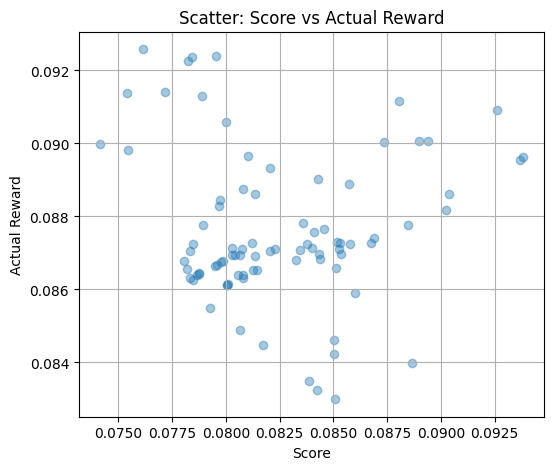

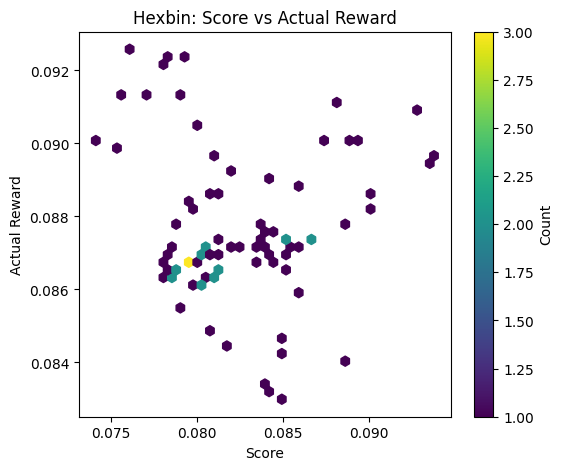

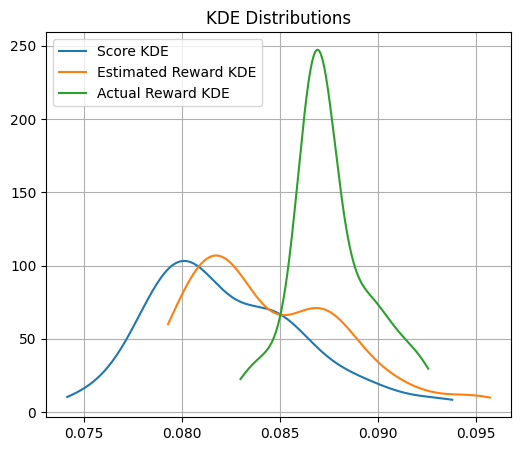

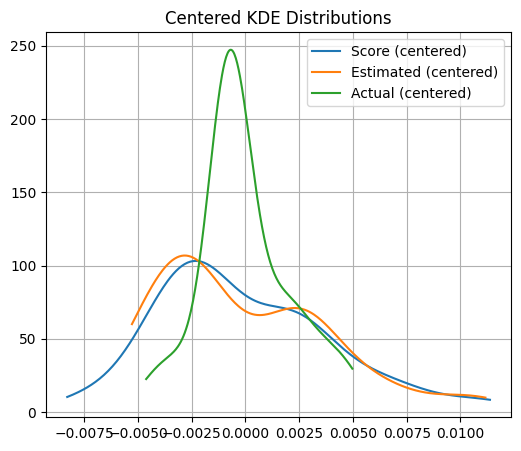

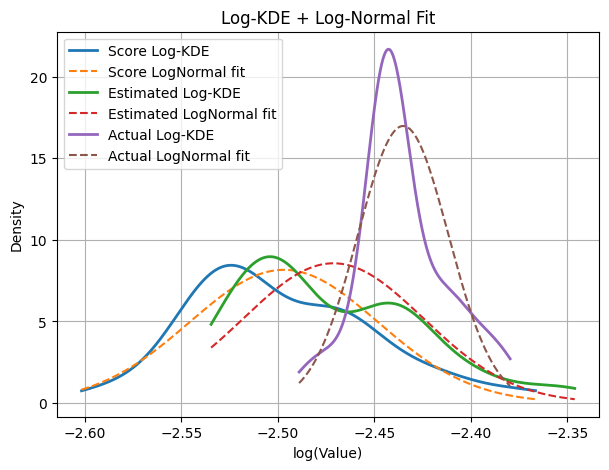

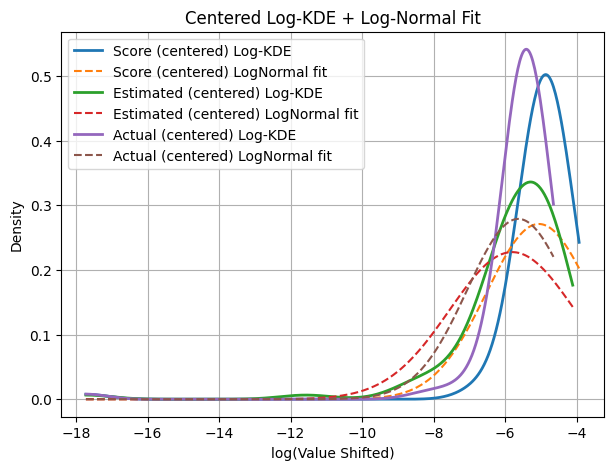

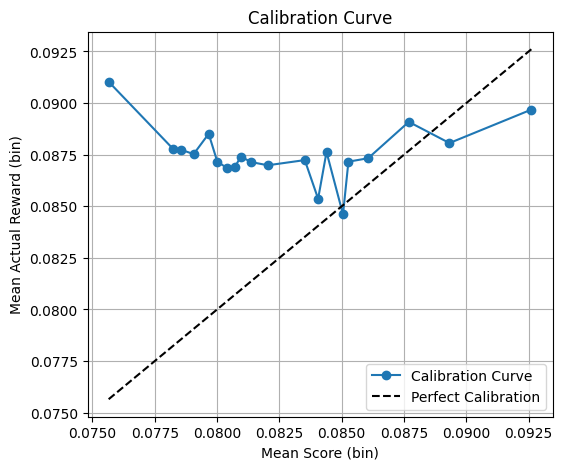

{'pearson_corr': np.float64(-0.047688885670777566),
 'spearman_score_actual': np.float64(0.035728100382093494),
 'spearman_est_actual': np.float64(0.26934289353271385),
 'ndcg_score_vs_actual_reward': np.float64(0.992880247727687),
 'ndcg_estimated_vs_actual_reward': np.float64(0.9929678292870726)}

In [17]:
from training_utils import compute_statistics_and_plots

compute_statistics_and_plots(all_dfs)